# Broadcast

## But : Faire un broadcast, départ décalé 


### Informations générales

#### Le nom de l'expérience : Nom du folder contenant les fichiers sources et résultats

In [1]:
experiment_name = "Time_Bcast"
crashed = True

#### Versions

In [2]:
%%bash -s
git log -n 1
python3 --version
R --version

commit 0f258c88b3382585a9057f468a066a8cb70d6e96
Author: Najwa Ez Zine <nezzine@fnancy>
Date:   Mon Jul 16 14:03:42 2018 +0200

    Automatic results update : Time_Bcast --- None  Guess
Python 3.5.3
R version 3.3.3 (2017-03-06) -- "Another Canoe"
Copyright (C) 2017 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
http://www.gnu.org/licenses/.



### Préparation de l'environnement (FRONTEND)

#### Installation des modules

In [3]:
%%bash -s
pip3 install --user execo
pip3 install --user requests

# Permet affichage pllus lisible avec couleurs
pip3 install --user termcolor

# Permettent d'utiliser R :
pip3 install --user rpy2
pip3 install --user tzlocal

  Using cached https://files.pythonhosted.org/packages/65/47/7e02164a2a3db50ed6d8a6ab1d6d60b69c4c3fdf57a284257925dfc12bda/requests-2.19.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bd/c9/6fdd990019071a4a32a5e7cb78a1d92c53851ef4f56f62a3486e6a7d8ffb/urllib3-1.23-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7c/e6/92ad559b7192d846975fc916b65f667c7b8c3a32bea7372340bfe9a15fa5/certifi-2018.4.16-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4b/2a/0276479a4b3caeb8a8c1af2f8e4355746a97fab05a372e4a2c6a6b876165/idna-2.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/67/4b/141a581104b1f6397bfa78ac9d43d8ad29a7ca43ea90a2d863fe3056e86a/six-1.11.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7f/ff/

#### Chargement des modules dans l'environnement

In [4]:
import execo
import math
import collections
import os
import sys
import json
import time
import random
import datetime
import re
import tzlocal

from execo import *
from execo_g5k import *
from execo_engine import *

from shutil import copy
from subprocess import check_output

from threading import Thread

from collections import deque, OrderedDict
from termcolor import *
from subprocess import *

#### Chargement de l'outil permettant l'utilisation de R

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
#install.packages('ggplot2')
#install.packages('dplyr')
#install.packages('tidyr')

NULL


In [7]:
%%R
packageVersion('ggplot2')

[1] ‘2.2.1’


In [8]:
%%R
packageVersion('dplyr')

[1] ‘0.7.6’


In [9]:
%%R
packageVersion('tidyr')

[1] ‘0.8.1’


### Tools

#### Affichage coloré

In [10]:
# Termcolor
# OPTIONS  : bold, dark, underline, blink, reverse, concealed

text = colored('Hello, World!', 'red', attrs = ['blink'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['dark'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['underline'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['bold'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['concealed'])
print(text)

cprint('Hello, World!', 'green', 'on_red',attrs = ['reverse'])

Hello, World!
Hello, World!
Hello, World!
Hello, World!
Hello, World!
Hello, World!


#### Affichage lisible d'un dictionnaire complexe

In [11]:
# Display more readable dict
# SOURCE : https://stackoverflow.com/questions/3229419/how-to-pretty-print-nested-dictionaries
def pretty(d, indent = 0):
    for key, value in d.items():
        print('\t' * indent + colored (str(key), "magenta"))
        if isinstance(value, type({})):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

### Préparation de l'environnement pour l'expérience

#### Paramètres réservation

In [12]:
# Nom du job
jobname = ' '
# Nombre de noeuds
nodecount = 2
# Temps réservation
walltime = "3:0:0" 

# filters out Nantes's econome cluster
resources_selection = " "
# -p \"cluster in ('ecotype','parasilo','graphene','griffon',grisou','uvb','paravance','genepi')\"" 

# Nancy
site = "nancy"

#Type de deploiement 
FILE_DEPLOY = True

#### Réservation

In [13]:
jobs = get_current_oar_jobs()
jobid = None
waiting_jobs = []
while jobs:
    j, site = jobs.pop()
    info = get_oar_job_info(j, site)
    if info['name'] == jobname:
        if info['state'] == 'Running':
            jobid = j
            print("A {} job is already running, using it. jobid is {}".format(jobname, jobid))
            break
        else:
            waiting_jobs.append(j)
if not jobid and not waiting_jobs:
    jobspec = OarSubmission(resources="/cluster=1/nodes={}".format(nodecount), walltime = walltime,
                            additional_options = resources_selection, job_type = "deploy", name = jobname)
    jobid, _ = oarsub([(jobspec, site)]).pop()
    print("New job submitted, jobid is {}".format(jobid))
elif not jobid:
    print("One or more {} jobs exist ({}) but are not running.\n"
          " Connect to the frontend to see what is happening, and/or run the cell again.".format(
          jobname, ", ".join([str(j) for j in waiting_jobs])))

A   job is already running, using it. jobid is 1614190


#### Récupération des infos sur les noeuds obtenus

###### Note : Si cette cellule met du temps à répondre, vérifier l'état de la réservation sur la frontale **oartstat -u username** ou via https://www.grid5000.fr/mediawiki/index.php/Status

In [14]:
nodes = get_oar_job_nodes(jobid)
nodes.sort(key = lambda n: n.address)
nodes

[Host('graphene-6.nancy.grid5000.fr'), Host('graphene-62.nancy.grid5000.fr')]

##### Déploiement de l'environnement : 2 options

###### Via fichier 

In [15]:
force_redeploy = False # set to True to force redeploying the OS on the nodes in the deployment section
environment_dsc_file = 'src/debian9-x64-bigdata-tutorial.yaml' # filename of the kadeploy environment file (YAML)

In [16]:
if (FILE_DEPLOY):
    deployment = Deployment(hosts = nodes, env_file = os.path.abspath(environment_dsc_file),
                        other_options = "-r ext4 --no-debug-mode")

    deploy_ok, deploy_failed = deploy(deployment, check_deployed_command = not force_redeploy,
                              stdout_handlers = [sys.stdout],
                              stderr_handlers = [sys.stderr])
else :
    deploy_ok, deploy_failed = deploy(Deployment(nodes, env_name = "debian9-x64-base",
                              other_options = "-r ext4 --no-debug-mode"),
                              stdout_handlers = [sys.stdout],
                              stderr_handlers = [sys.stderr])

In [17]:
print("Deployement status:\n* ok: {}\n* failed: {}".format(deploy_ok, deploy_failed))

Deployement status:
* ok: {'graphene-62.nancy.grid5000.fr', 'graphene-6.nancy.grid5000.fr'}
* failed: set()


#### Test : commande simple 'ls'

In [18]:
Remote_test = execo.action.Remote(cmd = 'ls',hosts = nodes, connection_params = None, process_args = None)
Remote_test.run().ok

True

#### Installation environnement/tools sur noeuds

In [19]:
if (not crashed):
    Remote_install = execo.action.Remote(cmd = 'apt-get install g++ libboost-all-dev && wget http://gforge.inria.fr/frs/download.php/latestfile/8/SimGrid-3.18.tar.gz && tar -xvf SimGrid-3.18.tar.gz && cd SimGrid-3.18 && cmake -DCMAKE_INSTALL_PREFIX=/usr/local -Denable_smpi=on -Denable_documentation=off && make -j && make check && make install -j',
                                         hosts = nodes,
                                         connection_params = {'user':'root'})
    Remote_install.run().ok

In [20]:
if (not crashed):
    Pajeng_install = execo.action.Remote(cmd = 'git clone git://github.com/schnorr/pajeng.git ; mkdir -p pajeng/build ; cd pajeng/build ; cmake .. ; make ; make install',
                                         hosts = nodes,
                                         connection_params = {'user':'root'}
                                        ).run().ok
    Pajeng_install

#### Version Simgrid

In [21]:
def remote_version(software):
    execo.action.Remote(cmd = 'touch version.txt &&' + str(software) + ' --version > version.txt', 
                        hosts = nodes, 
                        connection_params = {'user': 'root'}
                       ).run()

    version = ''

    for i in range(0, nodecount):
        execo.action.Get(hosts = nodes[i], remote_files = ['~/version.txt'],
                         local_location = './version-'
                                            + get_host_shortname(nodes[i]) + '.txt',
                         connection_params = {'user': 'root'}).run()
    
        version = version + execo.Process(cmd = 'cat ./version-'
                                                + get_host_shortname(nodes[i]) 
                                                + '.txt').run().stdout
        execo.Process(cmd = 'rm ./version-'
                            + get_host_shortname(nodes[i]) + '.txt').run()

    print(colored('VERSION : ' + str(software),"blue"), '\n' + version + '\n')
    return

remote_version('smpicc')
remote_version('g++')
remote_version('pj_dump')

VERSION : smpicc 
SimGrid version 3.18
SimGrid version 3.18


VERSION : g++ 
g++ (Debian 6.3.0-18) 6.3.0 20170516
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

g++ (Debian 6.3.0-18) 6.3.0 20170516
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



VERSION : pj_dump 

Development build at commit b9780a1 (2017-08-03 15:05:05 -0300)

Development build at commit b9780a1 (2017-08-03 15:05:05 -0300)




#### Chemins (à configurer)

In [22]:
path_base = "/home/nezzine/Stage-POLARIS/SimGrid/examples/SMPI/" + experiment_name
path_src = path_base + '/src/'
path_rslt = path_base + '/results/'

#### Traitement des données pour les calculs de D et S

In [23]:
# Intialise tableau
def init_tab(num, elt) :
    D = [elt] * num
    return D

# Parsing the results
def parser(num_node, date_precise):
    with open( path_rslt
               + date_precise.split('_')[0] + '/'
               + get_host_shortname(nodes[num_node]) + '_'
               + date_precise
               + '.txt') as f:
        return f.readlines()
    
# Converting and organizing data
def tab_conv(l, NPROCS, precision) :
    S = init_tab(NPROCS, None)
        
    # On récupère les données des fichiers
    # Un fichier contient des lignes telles que : From 0 -> S[0] : 0.0819526    
    for i in range(0, NPROCS) :
        line = l[i].split()
        S[int(line[1])] = round(float(line[5]), precision)
    return S

def delayer(num_node, NPROCS, date, precision):
    D = init_tab(NPROCS, 0.0)
    
    raw_data = parser(num_node, date)
    
    S = tab_conv(raw_data, NPROCS, precision)
    
    for p in range(0, NPROCS):
        D[p] = round(S[p] - min(S), precision)
    return [D, min(S)]

In [24]:
# Example
# delayer(0,10,'2018-06-04_12:38',2)

## SIMULATION

#### Mise en place de l'environnement (fichiers src simulation...) sur noeuds

In [25]:
def env_setup() :
    Src_dir = execo.action.Remote(cmd = 'mkdir -p experiments_src',
                                  hosts = nodes,
                                  connection_params = {'user': 'root'})
    Src_get = execo.action.Put(hosts = nodes,
                               local_files = [path_src
                                   + 'griffon.xml', path_src
                                   + 'griffon_hostfile.txt', path_src
                                   + 'broadcast.c', path_src 
                                   + 'Makefile'],
                                remote_location = '~/experiments_src',
                                connection_params = {'user': 'root'})
    Rslt_dir = execo.Process(cmd = 'mkdir -p '
                                  + path_rslt
                                  + datetime.datetime.now().strftime('%Y-%m-%d'))

# On récup les src
    if not (Src_dir.run().ok 
            and Src_get.run().ok 
            and Rslt_dir.run().ok):
        raise Error("Environnement could not be set : Check files")


#### Défintion du thread pour parallélisation de la simulation

In [26]:
# Thread pour la simulation // opt.
class ParSimer(Thread):

    """Thread chargé simplement d'afficher une lettre dans la console."""
    
    # Paramètrage du thread
    def __init__(self, i, MIN, MAX, N, DELAY):
        Thread.__init__(self)
        self.MIN = MIN
        self.MAX = MAX
        self.N = N
        self.DELAY = DELAY
        self.i = i
    
    # Set la valeur du délai
    def set_delay(self, delay):
        self.DELAY = delay
    
    def get_delay(self):
        return self.DELAY
    
    def get_MIN(self):
        return self.MIN
    
    def run(self):
        """Code à exécuter pendant l'exécution du thread."""
        if (DEBUG): 
            print(
                get_host_shortname(nodes[self.i]) + " => NPROCS = " + str(NPROCS)
             + " MIN = " + str(self.MIN)
             + " MAX = " + str(self.MAX)
             + " N = " + str(self.N)
             + " DELAY = '" + self.DELAY + "'\n"
            )
       
        # make run sur toutes la machine dont le thread s'occupe avec ses paramètres
        execo.action.Remote(cmd ='cd ~/experiments_src && make && make run NPROCS='
                                  + str(NPROCS) + ' MIN='+ str(self.MIN) 
                                  + ' MAX=' + str(self.MAX) + ' N=' + str(self.N)
                                  + " DELAY='" + self.DELAY
                                  + "'" , 
                            hosts = nodes[self.i], 
                            connection_params = {'user':'root'}).run().ok


#### Conversion string < = > int pour manipulation de D & S

In [27]:
# Formate le tableau en string pour pouvoir etre passé en ligne de commande
def format_cmd(data):
    return (' '.join(str(e) for e in data))

# Formate le string en tableau d'int pour être manipulé 
def unformat_cmd(data):
    return list(map(float, data.split()))

#### Génération du nouvel état initial

In [28]:
smart_table = {}

def reset_smart_table():
    smart_table = OrderedDict()
    return

def update_smart_table(final_state, t):
    final_state = unformat_cmd(final_state)
    smart_table.setdefault(t, [final_state,2])
    nb_val = smart_table[t][1]
    
    
    for i in range(NPROCS):
        smart_table[t][0][i] = (smart_table[t][0][i] * (nb_val - 1) + final_state[i]) / nb_val    
        
    smart_table[t][1] +=1

def generate_Dprime(NPROCS, border_inf, border_sup, precision):
    # Variable pour le stockage du nouveau D
    new_Dprime = []

    for p in range(NPROCS):
        random_value = random.uniform(border_inf[p], border_sup[p])
        round_value = round(random_value, precision)
        new_Dprime.append(round_value)
    return format_cmd(new_Dprime)

def generate_initial_state(mode, final_state, t):
    borders = unformat_cmd(final_state)
    # S'il n'y a pas de limite supérieure, on limite au double de l'état final obtenu
    double_Dprime = [(2 * (x)) for x in borders]
                      
    # Bornes pour le random 
    border_inf = init_tab(NPROCS, 0.0)
    border_sup = double_Dprime
    if (mode == "RAND_SUP") : 
        border_sup = borders
        new_initial_state =  generate_Dprime(NPROCS, border_inf, border_sup, precision)
    elif (mode == "RAND_INF") : 
        border_inf = borders
        new_initial_state = generate_Dprime(NPROCS, border_inf, border_sup, precision)
    elif (mode == "RAND") : 
        new_initial_state =  generate_Dprime(NPROCS, border_inf, border_sup, precision)
    elif (mode == "SMART_GUESS"):
        update_smart_table(final_state, t)
        new_initial_state = format_cmd(smart_table[t][0])
    return new_initial_state

#### Fonctions pour la simulation

In [29]:
def date_setup():
    date_precise = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M')
    date = date_precise.split('_')[0]
    return date_precise, date

def get_results(date_precise, q):
    date = date_precise.split('_')[0]
    execo.action.Get(
            hosts = nodes[q],
            remote_files = ['~/experiments_src/bcast_results.txt'],
            local_location = path_rslt
                            + date + '/' 
                            + get_host_shortname(nodes[q]) + '_'
                            + date_precise + '.txt', 
            connection_params = {'user': 'root'}
                       ).run().ok


def pj_dump(date, filename, q):
        execo.action.Remote(
            cmd = 'pj_dump --ignore-incomplete-links ./experiments_src/Time_Bcast.trace > ./experiments_src/Time_Bcast.csv && cp  ./experiments_src/Time_Bcast.csv  ./experiments_src/'+str(q)+'.csv',
            hosts = nodes[q],
            connection_params = {'user':'root'}
        ).run()

        execo.action.Remote(
            cmd = 'grep State '+ str(filename) + '.csv > ~/experiments_src/Time_Bcast.state.csv',
            hosts = nodes[q],
            connection_params = {'user': 'root'}
        ).run()
        execo.action.Remote(
            cmd = 'grep Link '+ str(filename) + '.csv > ~/experiments_src/Time_Bcast.link.csv',
            hosts = nodes[q],
            connection_params = {'user': 'root'}
        ).run()
        return
        
def get_csv(date, q):
        execo.action.Get(
            hosts = nodes[q],
            remote_files = ['~/experiments_src/*.csv'],
            local_location = path_base, 
            connection_params = {'user': 'root'}
        ).run()

def draw_ggplot(MIN, MAX, D):
            %R library(ggplot2)
            %R -i MIN 
            %R -i MAX 
            %R -i D
            %R df_state = read.csv("/home/nezzine/Stage-POLARIS/SimGrid/examples/SMPI/Time_Bcast/Time_Bcast.state.csv", header = F, strip.white=T)
            %R names(df_state) = c("Type", "Rank", "Container", "Start", "End", "Duration", "Level", "State"); 
            %R df_state = df_state[!(names(df_state) %in% c("Type","Container","Level"))]
            %R df_state$Rank = as.numeric(gsub("rank-","",df_state$Rank))
            %R gc = ggplot(data=df_state) + geom_rect(aes(xmin=Start, xmax=End, ymin=Rank, ymax=Rank+1,fill=State)) + scale_fill_brewer(palette="Set1")
            %R df_link = read.csv("/home/nezzine/Stage-POLARIS/SimGrid/examples/SMPI/Time_Bcast/Time_Bcast.link.csv", header=F, strip.white=T)
            %R names(df_link) = c("Type", "Level", "Container", "Start", "End", "Duration", "CommType", "Src", "Dst"); 
            %R df_link = df_link[!(names(df_link) %in% c("Type","Container","Level","CommType"))]
            %R df_link$Src = as.numeric(gsub("rank-","",df_link$Src))
            %R df_link$Dst = as.numeric(gsub("rank-","",df_link$Dst))
#             %R head(df_link)
            %R str(df_link)
#             %R step = round((max(df_link$End)/7),5)
            %R step = 0.0025
            %R print(df_state)
            %R print(df_link)
            %R print(gc + geom_segment(data = df_link, aes(x = Start, y = Src, xend = End, yend = Dst),arrow = arrow(length = unit(0.01, "npc"))) + scale_x_continuous(breaks = seq(0, 0.02, by = step)) + ggtitle(paste('Zone : ' , MIN, ' - ', MAX, '\nPour D', D) ))

--------------------------------------------  ROUND :  1   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 2 4 8 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 4 5 6 7 15 43 24 28 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.001487 0.001487    PMPI_Bcast
3     8 0.001487 0.004763 0.003276    PMPI_Bcast
4     8 0.004763 0.005846 0.001083    PMPI_Bcast
5     8 0.005846 0.007478 0.001632    PMPI_Bcast
6     8 0.007478 0.008228 0.000750    PMPI_Bcast
7     8 0.008228 0.009681 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.002940 0.002940    PMPI_Bcast
10    7 0.002940 0.004137 0.001197    PMPI_Bcast
11    7 0.004137 0.005846 0.001709    PMPI_Bcast
12    7 0.005846 0.006651 0.000805    PMPI_Bcast
13    7 0.006651 0.008502 0.001851    PMPI_Bcast
14    7 0.008502 0.009681 0.001179 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.002314 0.002314    PMPI_Bcast
17    6 0.002314 0.004137 0.001823    PMPI_Bcast
18    6 0.004137 0.005019 0.000882    PMPI_Bcast
19    6 0.005019 0.006972 0.001953    PMPI_Bcast
20    6 0.006972 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   0   1  0_1_-3334_4
2  0.000000 0.001487 0.001487   0   2  0_2_-3334_3
3  0.000000 0.001487 0.001487   0   4  0_4_-3334_2
4  0.000000 0.001487 0.001487   0   8  0_8_-3334_1
5  0.001487 0.002113 0.000626   1   2 1_2_-3334_12
6  0.001487 0.002113 0.000626   2   3  2_3_-3334_6
7  0.001487 0.002113 0.000626   8   9  8_9_-3334_8
8  0.001487 0.002314 0.000827   4   5 4_5_-3334_10
9  0.001487 0.002314 0.000827   4   6  4_6_-3334_7
10 0.002314 0.002940 0.000626   6   7 6_7_-3334_17
11 0.001487 0.003170 0.001683   1   9  1_9_-3334_5
12 0.001487 0.003170 0.001683   1   3 1_3_-3334_11
13 0.001487 0.003309 0.001822   1   5  1_5_-3334_9
14 0.002113 0.003796 0.001683   2   3 2_3_-3334_16
15 0.003170 0.003796 0.000626   3   4 3_4_-3334_19
16 0.003170 0.003796 0.000626   9   0 9_0_-3334_18
17 0.003309 0.004137 0.000828   5   6 5_6_-3334_21
18 0.003309 0.004137 0.000828   5   7 5_7_-3334_20
19 0.004137 0.004763 0.000626  

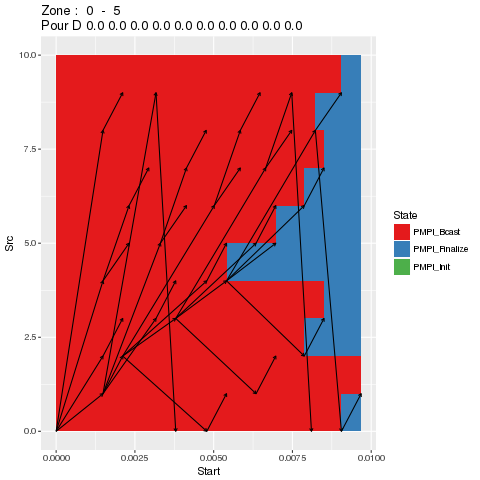

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  5 5 5 5 6 7 3 9 9 1 ...
 $ Dst     : num  6 7 9 3 7 8 4 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 22 17 25 32 13 39 43 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.002113 0.002113    PMPI_Bcast
3     8 0.002113 0.003170 0.001057    PMPI_Bcast
4     8 0.003170 0.003796 0.000626    PMPI_Bcast
5     8 0.003796 0.003796 0.000000    PMPI_Bcast
6     8 0.003796 0.008502 0.004706    PMPI_Bcast
7     8 0.008502 0.009681 0.001179 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.001487 0.001487    PMPI_Bcast
10    7 0.001487 0.002113 0.000626    PMPI_Bcast
11    7 0.002113 0.002113 0.000000    PMPI_Bcast
12    7 0.002113 0.006972 0.004859    PMPI_Bcast
13    7 0.006972 0.007876 0.000904    PMPI_Bcast
14    7 0.007876 0.009681 0.001805 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.001487 0.001487    PMPI_Bcast
17    6 0.001487 0.001487 0.000000    PMPI_Bcast
18    6 0.001487 0.005408 0.003921    PMPI_Bcast
19    6 0.005408 0.006346 0.000938    PMPI_Bcast
20    6 0.006346 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   5   6  5_6_-3334_4
2  0.000000 0.001487 0.001487   5   7  5_7_-3334_3
3  0.000000 0.001487 0.001487   5   9  5_9_-3334_2
4  0.000000 0.001487 0.001487   5   3  5_3_-3334_1
5  0.001487 0.002113 0.000626   6   7 6_7_-3334_12
6  0.001487 0.002113 0.000626   7   8  7_8_-3334_6
7  0.001487 0.002113 0.000626   3   4  3_4_-3334_8
8  0.001487 0.002314 0.000827   9   0 9_0_-3334_10
9  0.001487 0.002314 0.000827   9   1  9_1_-3334_7
10 0.002314 0.002940 0.000626   1   2 1_2_-3334_17
11 0.001487 0.003170 0.001683   6   4  6_4_-3334_5
12 0.001487 0.003170 0.001683   6   8 6_8_-3334_11
13 0.001487 0.003309 0.001822   6   0  6_0_-3334_9
14 0.002113 0.003796 0.001683   7   8 7_8_-3334_16
15 0.003170 0.003796 0.000626   8   9 8_9_-3334_19
16 0.003170 0.003796 0.000626   4   5 4_5_-3334_18
17 0.003309 0.004137 0.000828   0   1 0_1_-3334_21
18 0.003309 0.004137 0.000828   0   2 0_2_-3334_20
19 0.004137 0.004763 0.000626  

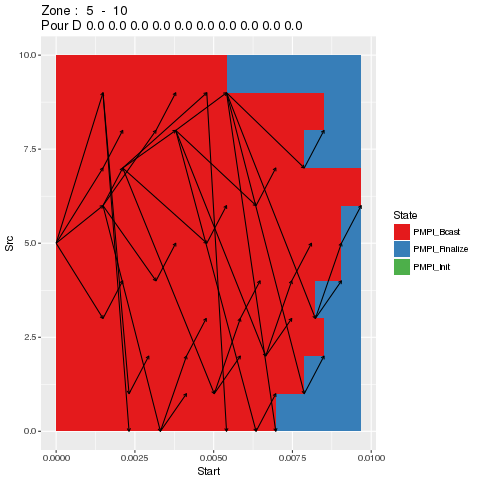

T_curr :  0
total execution time :  0

merging : 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

  || RESULTS || 

T_curr :  5
total execution time :  0.0054

  || ANALYSIS || 

--------------------------------------------  ROUND :  2   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002286 0.002090    PMPI_Bcast
3     8 0.002286 0.003332 0.001046    PMPI_Bcast
4     8 0.003332 0.003958 0.000626    PMPI_Bcast
5     8 0.003958 0.003958 0.000000    PMPI_Bcast
6     8 0.003958 0.008650 0.004692    PMPI_Bcast
7     8 0.008650 0.009834 0.001184 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001660 0.001443    PMPI_Bcast
10    7 0.001660 0.002286 0.000626    PMPI_Bcast
11    7 0.002286 0.002286 0.000000    PMPI_Bcast
12    7 0.002286 0.007123 0.004837    PMPI_Bcast
13    7 0.007123 0.008024 0.000901    PMPI_Bcast
14    7 0.008024 0.009834 0.001810 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000175 0.001569 0.001394    PMPI_Bcast
17    6 0.001569 0.001569 0.000000    PMPI_Bcast
18    6 0.001569 0.005564 0.003995    PMPI_Bcast
19    6 0.005564 0.006497 0.000933    PMPI_Bcast
20    6 0.006497 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   5   6  5_6_-3334_4
2  0.000112 0.001660 0.001548   5   7  5_7_-3334_3
3  0.000112 0.001660 0.001548   5   3  5_3_-3334_1
4  0.000112 0.001679 0.001567   5   9  5_9_-3334_2
5  0.001569 0.002286 0.000717   6   7  6_7_-3334_8
6  0.001660 0.002286 0.000626   3   4 3_4_-3334_10
7  0.001660 0.002286 0.000626   7   8  7_8_-3334_9
8  0.001679 0.002506 0.000827   9   0 9_0_-3334_12
9  0.001679 0.002506 0.000827   9   1 9_1_-3334_11
10 0.002506 0.003132 0.000626   1   2 1_2_-3334_17
11 0.001569 0.003332 0.001763   6   8  6_8_-3334_7
12 0.001569 0.003332 0.001763   6   4  6_4_-3334_5
13 0.001569 0.003486 0.001917   6   0  6_0_-3334_6
14 0.002286 0.003958 0.001672   7   8 7_8_-3334_16
15 0.003332 0.003958 0.000626   4   5 4_5_-3334_19
16 0.003332 0.003958 0.000626   8   9 8_9_-3334_18
17 0.003486 0.004313 0.000827   0   1 0_1_-3334_21
18 0.003486 0.004313 0.000827   0   2 0_2_-3334_20
19 0.002286 0.004938 0.002652  

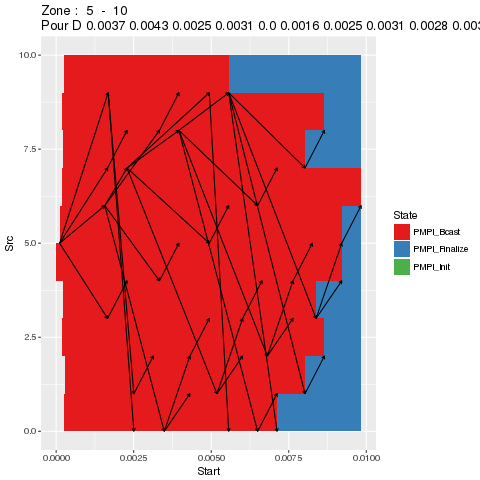

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001660 0.001443    PMPI_Bcast
3     8 0.001660 0.004939 0.003279    PMPI_Bcast
4     8 0.004939 0.006012 0.001073    PMPI_Bcast
5     8 0.006012 0.007636 0.001624    PMPI_Bcast
6     8 0.007636 0.008380 0.000744    PMPI_Bcast
7     8 0.008380 0.009834 0.001454 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000175 0.003132 0.002957    PMPI_Bcast
10    7 0.003132 0.004313 0.001181    PMPI_Bcast
11    7 0.004313 0.006012 0.001699    PMPI_Bcast
12    7 0.006012 0.006809 0.000797    PMPI_Bcast
13    7 0.006809 0.008650 0.001841    PMPI_Bcast
14    7 0.008650 0.009834 0.001184 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000301 0.002506 0.002205    PMPI_Bcast
17    6 0.002506 0.004313 0.001807    PMPI_Bcast
18    6 0.004313 0.005185 0.000872    PMPI_Bcast
19    6 0.005185 0.007123 0.001938    PMPI_Bcast
20    6 0.007123 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   0   1  0_1_-3334_4
2  0.000112 0.001660 0.001548   0   8  0_8_-3334_1
3  0.000112 0.001660 0.001548   0   2  0_2_-3334_3
4  0.000112 0.001679 0.001567   0   4  0_4_-3334_2
5  0.001569 0.002286 0.000717   1   2  1_2_-3334_8
6  0.001660 0.002286 0.000626   2   3 2_3_-3334_10
7  0.001660 0.002286 0.000626   8   9  8_9_-3334_9
8  0.001679 0.002506 0.000827   4   5 4_5_-3334_12
9  0.001679 0.002506 0.000827   4   6 4_6_-3334_11
10 0.002506 0.003132 0.000626   6   7 6_7_-3334_17
11 0.001569 0.003332 0.001763   1   9  1_9_-3334_5
12 0.001569 0.003332 0.001763   1   3  1_3_-3334_7
13 0.001569 0.003486 0.001917   1   5  1_5_-3334_6
14 0.002286 0.003958 0.001672   2   3 2_3_-3334_16
15 0.003332 0.003958 0.000626   3   4 3_4_-3334_19
16 0.003332 0.003958 0.000626   9   0 9_0_-3334_18
17 0.003486 0.004313 0.000827   5   6 5_6_-3334_21
18 0.003486 0.004313 0.000827   5   7 5_7_-3334_20
19 0.002286 0.004938 0.002652  

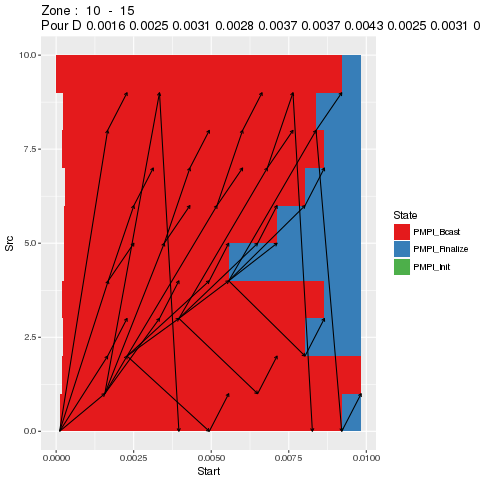

T_curr :  5
total execution time :  0.0054

merging : 0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
merging : 0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0
****** SUCCESS : 2

  || RESULTS || 

T_curr :  15
total execution time :  0.0166

  || ANALYSIS || 

--------------------------------------------  ROUND :  3   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

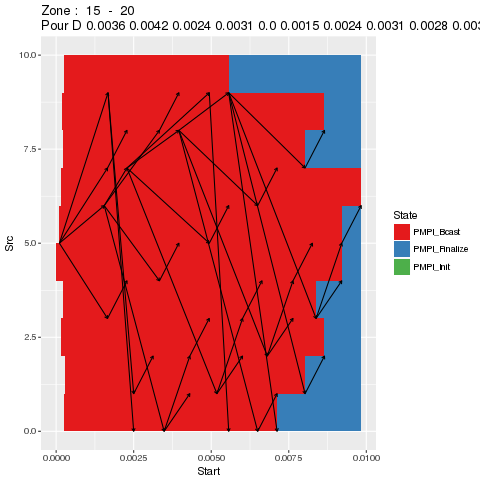

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 2 4 8 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 4 5 6 7 15 43 24 28 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.001487 0.001487    PMPI_Bcast
3     8 0.001487 0.004763 0.003276    PMPI_Bcast
4     8 0.004763 0.005846 0.001083    PMPI_Bcast
5     8 0.005846 0.007478 0.001632    PMPI_Bcast
6     8 0.007478 0.008228 0.000750    PMPI_Bcast
7     8 0.008228 0.009681 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.002940 0.002940    PMPI_Bcast
10    7 0.002940 0.004137 0.001197    PMPI_Bcast
11    7 0.004137 0.005846 0.001709    PMPI_Bcast
12    7 0.005846 0.006651 0.000805    PMPI_Bcast
13    7 0.006651 0.008502 0.001851    PMPI_Bcast
14    7 0.008502 0.009681 0.001179 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.002314 0.002314    PMPI_Bcast
17    6 0.002314 0.004137 0.001823    PMPI_Bcast
18    6 0.004137 0.005019 0.000882    PMPI_Bcast
19    6 0.005019 0.006972 0.001953    PMPI_Bcast
20    6 0.006972 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   0   1  0_1_-3334_4
2  0.000000 0.001487 0.001487   0   2  0_2_-3334_3
3  0.000000 0.001487 0.001487   0   4  0_4_-3334_2
4  0.000000 0.001487 0.001487   0   8  0_8_-3334_1
5  0.001487 0.002113 0.000626   1   2 1_2_-3334_12
6  0.001487 0.002113 0.000626   2   3  2_3_-3334_6
7  0.001487 0.002113 0.000626   8   9  8_9_-3334_8
8  0.001487 0.002314 0.000827   4   5 4_5_-3334_10
9  0.001487 0.002314 0.000827   4   6  4_6_-3334_7
10 0.002314 0.002940 0.000626   6   7 6_7_-3334_17
11 0.001487 0.003170 0.001683   1   9  1_9_-3334_5
12 0.001487 0.003170 0.001683   1   3 1_3_-3334_11
13 0.001487 0.003309 0.001822   1   5  1_5_-3334_9
14 0.002113 0.003796 0.001683   2   3 2_3_-3334_16
15 0.003170 0.003796 0.000626   3   4 3_4_-3334_19
16 0.003170 0.003796 0.000626   9   0 9_0_-3334_18
17 0.003309 0.004137 0.000828   5   6 5_6_-3334_21
18 0.003309 0.004137 0.000828   5   7 5_7_-3334_20
19 0.004137 0.004763 0.000626  

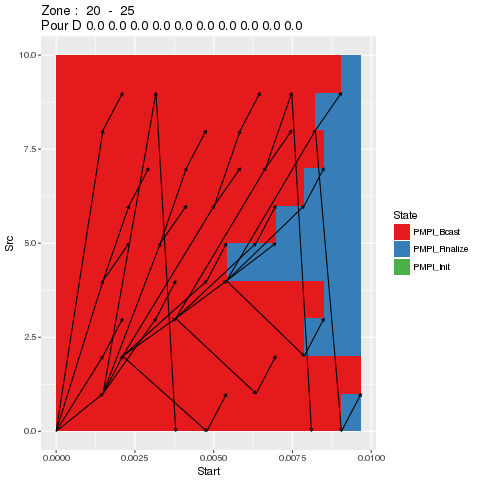

T_curr :  15
total execution time :  0.0166

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

T_curr :  20
total execution time :  0.0222

  || ANALYSIS || 

--------------------------------------------  ROUND :  4   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

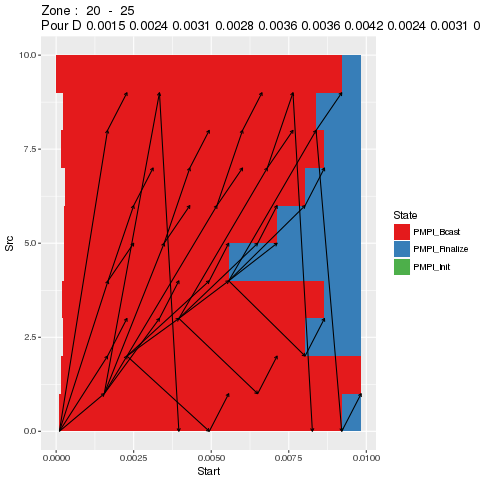

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002286 0.002090    PMPI_Bcast
3     8 0.002286 0.003332 0.001046    PMPI_Bcast
4     8 0.003332 0.003958 0.000626    PMPI_Bcast
5     8 0.003958 0.003958 0.000000    PMPI_Bcast
6     8 0.003958 0.008650 0.004692    PMPI_Bcast
7     8 0.008650 0.009834 0.001184 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001660 0.001443    PMPI_Bcast
10    7 0.001660 0.002286 0.000626    PMPI_Bcast
11    7 0.002286 0.002286 0.000000    PMPI_Bcast
12    7 0.002286 0.007123 0.004837    PMPI_Bcast
13    7 0.007123 0.008024 0.000901    PMPI_Bcast
14    7 0.008024 0.009834 0.001810 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000175 0.001569 0.001394    PMPI_Bcast
17    6 0.001569 0.001569 0.000000    PMPI_Bcast
18    6 0.001569 0.005564 0.003995    PMPI_Bcast
19    6 0.005564 0.006497 0.000933    PMPI_Bcast
20    6 0.006497 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   5   6  5_6_-3334_4
2  0.000112 0.001660 0.001548   5   7  5_7_-3334_3
3  0.000112 0.001660 0.001548   5   3  5_3_-3334_1
4  0.000112 0.001679 0.001567   5   9  5_9_-3334_2
5  0.001569 0.002286 0.000717   6   7  6_7_-3334_8
6  0.001660 0.002286 0.000626   3   4 3_4_-3334_10
7  0.001660 0.002286 0.000626   7   8  7_8_-3334_9
8  0.001679 0.002506 0.000827   9   0 9_0_-3334_12
9  0.001679 0.002506 0.000827   9   1 9_1_-3334_11
10 0.002506 0.003132 0.000626   1   2 1_2_-3334_17
11 0.001569 0.003332 0.001763   6   8  6_8_-3334_7
12 0.001569 0.003332 0.001763   6   4  6_4_-3334_5
13 0.001569 0.003486 0.001917   6   0  6_0_-3334_6
14 0.002286 0.003958 0.001672   7   8 7_8_-3334_16
15 0.003332 0.003958 0.000626   4   5 4_5_-3334_19
16 0.003332 0.003958 0.000626   8   9 8_9_-3334_18
17 0.003486 0.004313 0.000827   0   1 0_1_-3334_21
18 0.003486 0.004313 0.000827   0   2 0_2_-3334_20
19 0.002286 0.004938 0.002652  

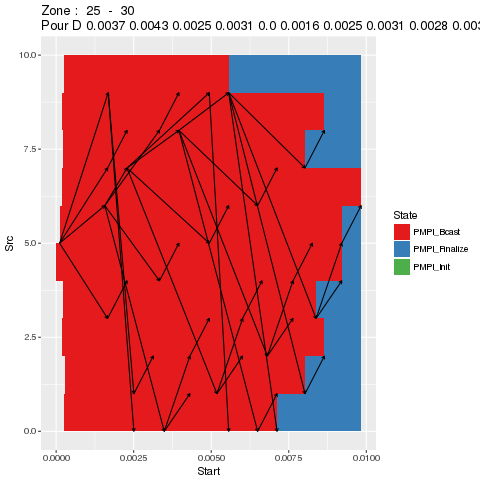

T_curr :  20
total execution time :  0.0222

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
merging : 0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
****** SUCCESS : 2

  || RESULTS || 

T_curr :  30
total execution time :  0.0334

  || ANALYSIS || 

--------------------------------------------  ROUND :  5   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

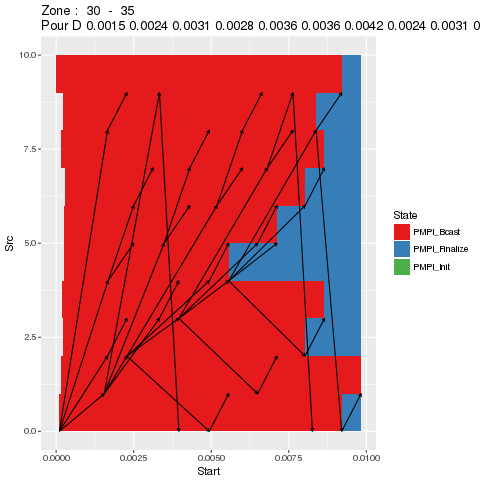

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  5 5 5 5 6 7 3 9 9 1 ...
 $ Dst     : num  6 7 9 3 7 8 4 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 22 17 25 32 13 39 43 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.002113 0.002113    PMPI_Bcast
3     8 0.002113 0.003170 0.001057    PMPI_Bcast
4     8 0.003170 0.003796 0.000626    PMPI_Bcast
5     8 0.003796 0.003796 0.000000    PMPI_Bcast
6     8 0.003796 0.008502 0.004706    PMPI_Bcast
7     8 0.008502 0.009681 0.001179 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.001487 0.001487    PMPI_Bcast
10    7 0.001487 0.002113 0.000626    PMPI_Bcast
11    7 0.002113 0.002113 0.000000    PMPI_Bcast
12    7 0.002113 0.006972 0.004859    PMPI_Bcast
13    7 0.006972 0.007876 0.000904    PMPI_Bcast
14    7 0.007876 0.009681 0.001805 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.001487 0.001487    PMPI_Bcast
17    6 0.001487 0.001487 0.000000    PMPI_Bcast
18    6 0.001487 0.005408 0.003921    PMPI_Bcast
19    6 0.005408 0.006346 0.000938    PMPI_Bcast
20    6 0.006346 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   5   6  5_6_-3334_4
2  0.000000 0.001487 0.001487   5   7  5_7_-3334_3
3  0.000000 0.001487 0.001487   5   9  5_9_-3334_2
4  0.000000 0.001487 0.001487   5   3  5_3_-3334_1
5  0.001487 0.002113 0.000626   6   7 6_7_-3334_12
6  0.001487 0.002113 0.000626   7   8  7_8_-3334_6
7  0.001487 0.002113 0.000626   3   4  3_4_-3334_8
8  0.001487 0.002314 0.000827   9   0 9_0_-3334_10
9  0.001487 0.002314 0.000827   9   1  9_1_-3334_7
10 0.002314 0.002940 0.000626   1   2 1_2_-3334_17
11 0.001487 0.003170 0.001683   6   4  6_4_-3334_5
12 0.001487 0.003170 0.001683   6   8 6_8_-3334_11
13 0.001487 0.003309 0.001822   6   0  6_0_-3334_9
14 0.002113 0.003796 0.001683   7   8 7_8_-3334_16
15 0.003170 0.003796 0.000626   8   9 8_9_-3334_19
16 0.003170 0.003796 0.000626   4   5 4_5_-3334_18
17 0.003309 0.004137 0.000828   0   1 0_1_-3334_21
18 0.003309 0.004137 0.000828   0   2 0_2_-3334_20
19 0.004137 0.004763 0.000626  

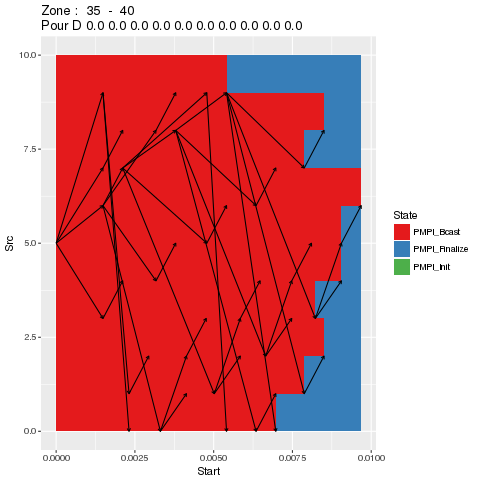

T_curr :  30
total execution time :  0.0334

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

T_curr :  35
total execution time :  0.039

  || ANALYSIS || 

--------------------------------------------  ROUND :  6   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

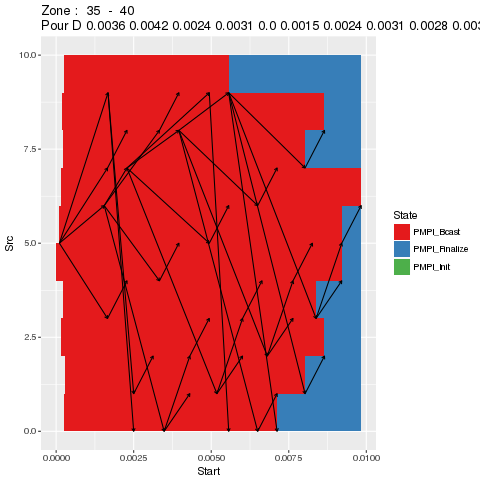

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001660 0.001443    PMPI_Bcast
3     8 0.001660 0.004939 0.003279    PMPI_Bcast
4     8 0.004939 0.006012 0.001073    PMPI_Bcast
5     8 0.006012 0.007636 0.001624    PMPI_Bcast
6     8 0.007636 0.008380 0.000744    PMPI_Bcast
7     8 0.008380 0.009834 0.001454 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000175 0.003132 0.002957    PMPI_Bcast
10    7 0.003132 0.004313 0.001181    PMPI_Bcast
11    7 0.004313 0.006012 0.001699    PMPI_Bcast
12    7 0.006012 0.006809 0.000797    PMPI_Bcast
13    7 0.006809 0.008650 0.001841    PMPI_Bcast
14    7 0.008650 0.009834 0.001184 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000301 0.002506 0.002205    PMPI_Bcast
17    6 0.002506 0.004313 0.001807    PMPI_Bcast
18    6 0.004313 0.005185 0.000872    PMPI_Bcast
19    6 0.005185 0.007123 0.001938    PMPI_Bcast
20    6 0.007123 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   0   1  0_1_-3334_4
2  0.000112 0.001660 0.001548   0   8  0_8_-3334_1
3  0.000112 0.001660 0.001548   0   2  0_2_-3334_3
4  0.000112 0.001679 0.001567   0   4  0_4_-3334_2
5  0.001569 0.002286 0.000717   1   2  1_2_-3334_8
6  0.001660 0.002286 0.000626   2   3 2_3_-3334_10
7  0.001660 0.002286 0.000626   8   9  8_9_-3334_9
8  0.001679 0.002506 0.000827   4   5 4_5_-3334_12
9  0.001679 0.002506 0.000827   4   6 4_6_-3334_11
10 0.002506 0.003132 0.000626   6   7 6_7_-3334_17
11 0.001569 0.003332 0.001763   1   9  1_9_-3334_5
12 0.001569 0.003332 0.001763   1   3  1_3_-3334_7
13 0.001569 0.003486 0.001917   1   5  1_5_-3334_6
14 0.002286 0.003958 0.001672   2   3 2_3_-3334_16
15 0.003332 0.003958 0.000626   3   4 3_4_-3334_19
16 0.003332 0.003958 0.000626   9   0 9_0_-3334_18
17 0.003486 0.004313 0.000827   5   6 5_6_-3334_21
18 0.003486 0.004313 0.000827   5   7 5_7_-3334_20
19 0.002286 0.004938 0.002652  

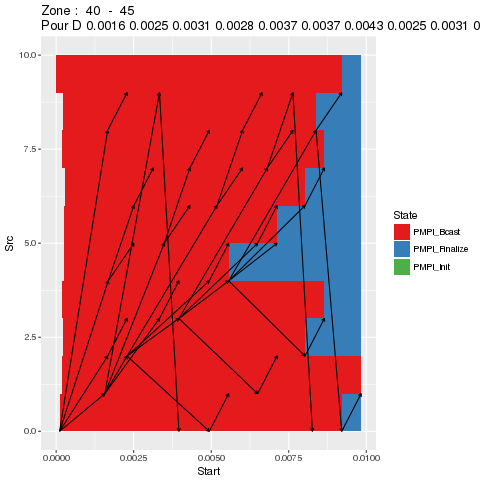

T_curr :  35
total execution time :  0.039

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
merging : 0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0
****** SUCCESS : 2

  || RESULTS || 

T_curr :  45
total execution time :  0.0502

  || ANALYSIS || 

--------------------------------------------  ROUND :  7   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

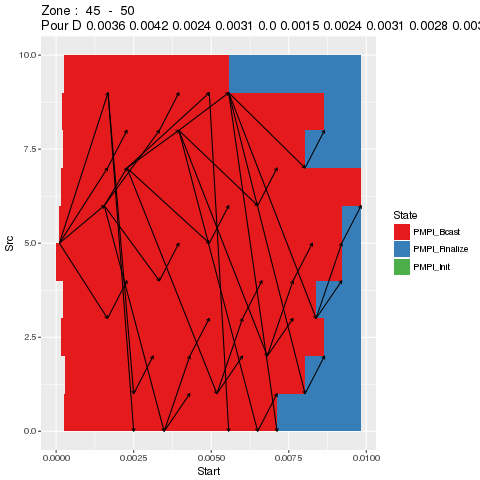

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 2 4 8 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 4 5 6 7 15 43 24 28 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.001487 0.001487    PMPI_Bcast
3     8 0.001487 0.004763 0.003276    PMPI_Bcast
4     8 0.004763 0.005846 0.001083    PMPI_Bcast
5     8 0.005846 0.007478 0.001632    PMPI_Bcast
6     8 0.007478 0.008228 0.000750    PMPI_Bcast
7     8 0.008228 0.009681 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.002940 0.002940    PMPI_Bcast
10    7 0.002940 0.004137 0.001197    PMPI_Bcast
11    7 0.004137 0.005846 0.001709    PMPI_Bcast
12    7 0.005846 0.006651 0.000805    PMPI_Bcast
13    7 0.006651 0.008502 0.001851    PMPI_Bcast
14    7 0.008502 0.009681 0.001179 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.002314 0.002314    PMPI_Bcast
17    6 0.002314 0.004137 0.001823    PMPI_Bcast
18    6 0.004137 0.005019 0.000882    PMPI_Bcast
19    6 0.005019 0.006972 0.001953    PMPI_Bcast
20    6 0.006972 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   0   1  0_1_-3334_4
2  0.000000 0.001487 0.001487   0   2  0_2_-3334_3
3  0.000000 0.001487 0.001487   0   4  0_4_-3334_2
4  0.000000 0.001487 0.001487   0   8  0_8_-3334_1
5  0.001487 0.002113 0.000626   1   2 1_2_-3334_12
6  0.001487 0.002113 0.000626   2   3  2_3_-3334_6
7  0.001487 0.002113 0.000626   8   9  8_9_-3334_8
8  0.001487 0.002314 0.000827   4   5 4_5_-3334_10
9  0.001487 0.002314 0.000827   4   6  4_6_-3334_7
10 0.002314 0.002940 0.000626   6   7 6_7_-3334_17
11 0.001487 0.003170 0.001683   1   9  1_9_-3334_5
12 0.001487 0.003170 0.001683   1   3 1_3_-3334_11
13 0.001487 0.003309 0.001822   1   5  1_5_-3334_9
14 0.002113 0.003796 0.001683   2   3 2_3_-3334_16
15 0.003170 0.003796 0.000626   3   4 3_4_-3334_19
16 0.003170 0.003796 0.000626   9   0 9_0_-3334_18
17 0.003309 0.004137 0.000828   5   6 5_6_-3334_21
18 0.003309 0.004137 0.000828   5   7 5_7_-3334_20
19 0.004137 0.004763 0.000626  

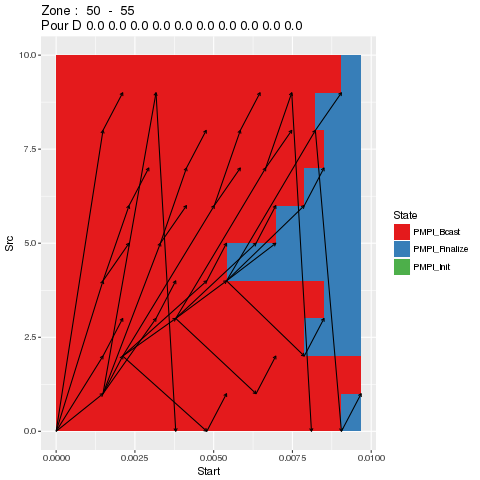

T_curr :  45
total execution time :  0.0502

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

T_curr :  50
total execution time :  0.0558

  || ANALYSIS || 

--------------------------------------------  ROUND :  8   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

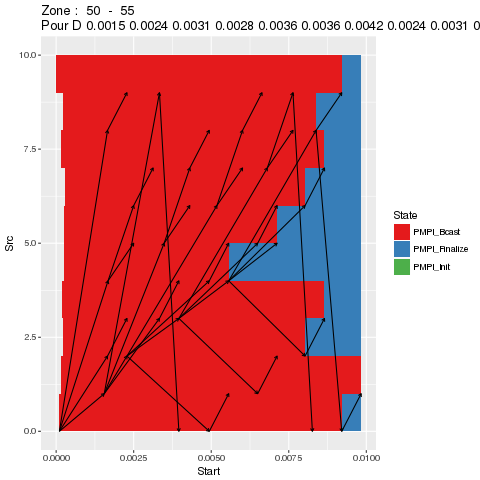

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002286 0.002090    PMPI_Bcast
3     8 0.002286 0.003332 0.001046    PMPI_Bcast
4     8 0.003332 0.003958 0.000626    PMPI_Bcast
5     8 0.003958 0.003958 0.000000    PMPI_Bcast
6     8 0.003958 0.008650 0.004692    PMPI_Bcast
7     8 0.008650 0.009834 0.001184 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001660 0.001443    PMPI_Bcast
10    7 0.001660 0.002286 0.000626    PMPI_Bcast
11    7 0.002286 0.002286 0.000000    PMPI_Bcast
12    7 0.002286 0.007123 0.004837    PMPI_Bcast
13    7 0.007123 0.008024 0.000901    PMPI_Bcast
14    7 0.008024 0.009834 0.001810 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000175 0.001569 0.001394    PMPI_Bcast
17    6 0.001569 0.001569 0.000000    PMPI_Bcast
18    6 0.001569 0.005564 0.003995    PMPI_Bcast
19    6 0.005564 0.006497 0.000933    PMPI_Bcast
20    6 0.006497 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   5   6  5_6_-3334_4
2  0.000112 0.001660 0.001548   5   7  5_7_-3334_3
3  0.000112 0.001660 0.001548   5   3  5_3_-3334_1
4  0.000112 0.001679 0.001567   5   9  5_9_-3334_2
5  0.001569 0.002286 0.000717   6   7  6_7_-3334_8
6  0.001660 0.002286 0.000626   3   4 3_4_-3334_10
7  0.001660 0.002286 0.000626   7   8  7_8_-3334_9
8  0.001679 0.002506 0.000827   9   0 9_0_-3334_12
9  0.001679 0.002506 0.000827   9   1 9_1_-3334_11
10 0.002506 0.003132 0.000626   1   2 1_2_-3334_17
11 0.001569 0.003332 0.001763   6   8  6_8_-3334_7
12 0.001569 0.003332 0.001763   6   4  6_4_-3334_5
13 0.001569 0.003486 0.001917   6   0  6_0_-3334_6
14 0.002286 0.003958 0.001672   7   8 7_8_-3334_16
15 0.003332 0.003958 0.000626   4   5 4_5_-3334_19
16 0.003332 0.003958 0.000626   8   9 8_9_-3334_18
17 0.003486 0.004313 0.000827   0   1 0_1_-3334_21
18 0.003486 0.004313 0.000827   0   2 0_2_-3334_20
19 0.002286 0.004938 0.002652  

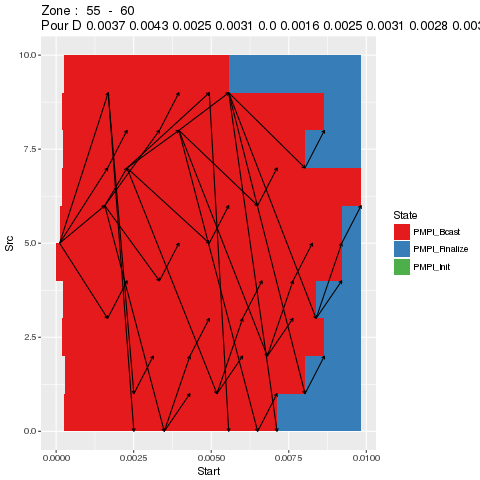

T_curr :  50
total execution time :  0.0558

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
merging : 0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
****** SUCCESS : 2

  || RESULTS || 

T_curr :  60
total execution time :  0.067

  || ANALYSIS || 

--------------------------------------------  ROUND :  9   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

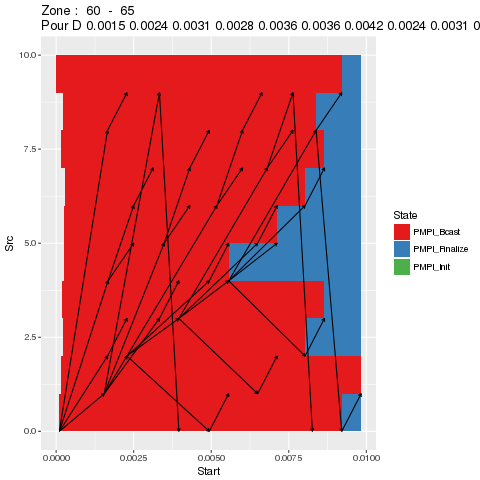

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  5 5 5 5 6 7 3 9 9 1 ...
 $ Dst     : num  6 7 9 3 7 8 4 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 22 17 25 32 13 39 43 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.002113 0.002113    PMPI_Bcast
3     8 0.002113 0.003170 0.001057    PMPI_Bcast
4     8 0.003170 0.003796 0.000626    PMPI_Bcast
5     8 0.003796 0.003796 0.000000    PMPI_Bcast
6     8 0.003796 0.008502 0.004706    PMPI_Bcast
7     8 0.008502 0.009681 0.001179 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.001487 0.001487    PMPI_Bcast
10    7 0.001487 0.002113 0.000626    PMPI_Bcast
11    7 0.002113 0.002113 0.000000    PMPI_Bcast
12    7 0.002113 0.006972 0.004859    PMPI_Bcast
13    7 0.006972 0.007876 0.000904    PMPI_Bcast
14    7 0.007876 0.009681 0.001805 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.001487 0.001487    PMPI_Bcast
17    6 0.001487 0.001487 0.000000    PMPI_Bcast
18    6 0.001487 0.005408 0.003921    PMPI_Bcast
19    6 0.005408 0.006346 0.000938    PMPI_Bcast
20    6 0.006346 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   5   6  5_6_-3334_4
2  0.000000 0.001487 0.001487   5   7  5_7_-3334_3
3  0.000000 0.001487 0.001487   5   9  5_9_-3334_2
4  0.000000 0.001487 0.001487   5   3  5_3_-3334_1
5  0.001487 0.002113 0.000626   6   7 6_7_-3334_12
6  0.001487 0.002113 0.000626   7   8  7_8_-3334_6
7  0.001487 0.002113 0.000626   3   4  3_4_-3334_8
8  0.001487 0.002314 0.000827   9   0 9_0_-3334_10
9  0.001487 0.002314 0.000827   9   1  9_1_-3334_7
10 0.002314 0.002940 0.000626   1   2 1_2_-3334_17
11 0.001487 0.003170 0.001683   6   4  6_4_-3334_5
12 0.001487 0.003170 0.001683   6   8 6_8_-3334_11
13 0.001487 0.003309 0.001822   6   0  6_0_-3334_9
14 0.002113 0.003796 0.001683   7   8 7_8_-3334_16
15 0.003170 0.003796 0.000626   8   9 8_9_-3334_19
16 0.003170 0.003796 0.000626   4   5 4_5_-3334_18
17 0.003309 0.004137 0.000828   0   1 0_1_-3334_21
18 0.003309 0.004137 0.000828   0   2 0_2_-3334_20
19 0.004137 0.004763 0.000626  

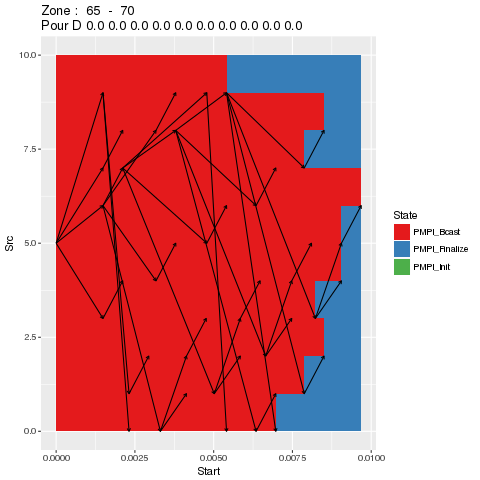

T_curr :  60
total execution time :  0.067

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

T_curr :  65
total execution time :  0.0726

  || ANALYSIS || 

--------------------------------------------  ROUND :  10   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

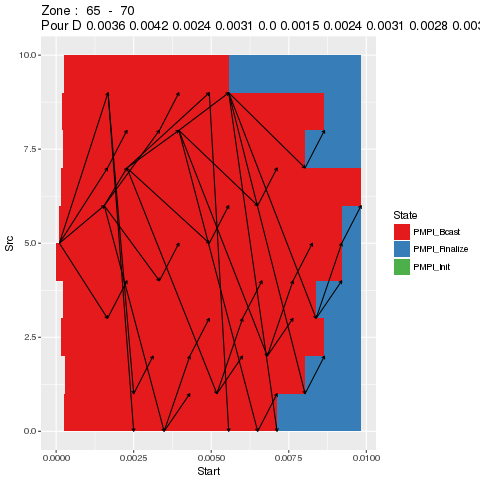

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001660 0.001443    PMPI_Bcast
3     8 0.001660 0.004939 0.003279    PMPI_Bcast
4     8 0.004939 0.006012 0.001073    PMPI_Bcast
5     8 0.006012 0.007636 0.001624    PMPI_Bcast
6     8 0.007636 0.008380 0.000744    PMPI_Bcast
7     8 0.008380 0.009834 0.001454 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000175 0.003132 0.002957    PMPI_Bcast
10    7 0.003132 0.004313 0.001181    PMPI_Bcast
11    7 0.004313 0.006012 0.001699    PMPI_Bcast
12    7 0.006012 0.006809 0.000797    PMPI_Bcast
13    7 0.006809 0.008650 0.001841    PMPI_Bcast
14    7 0.008650 0.009834 0.001184 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000301 0.002506 0.002205    PMPI_Bcast
17    6 0.002506 0.004313 0.001807    PMPI_Bcast
18    6 0.004313 0.005185 0.000872    PMPI_Bcast
19    6 0.005185 0.007123 0.001938    PMPI_Bcast
20    6 0.007123 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   0   1  0_1_-3334_4
2  0.000112 0.001660 0.001548   0   8  0_8_-3334_1
3  0.000112 0.001660 0.001548   0   2  0_2_-3334_3
4  0.000112 0.001679 0.001567   0   4  0_4_-3334_2
5  0.001569 0.002286 0.000717   1   2  1_2_-3334_8
6  0.001660 0.002286 0.000626   2   3 2_3_-3334_10
7  0.001660 0.002286 0.000626   8   9  8_9_-3334_9
8  0.001679 0.002506 0.000827   4   5 4_5_-3334_12
9  0.001679 0.002506 0.000827   4   6 4_6_-3334_11
10 0.002506 0.003132 0.000626   6   7 6_7_-3334_17
11 0.001569 0.003332 0.001763   1   9  1_9_-3334_5
12 0.001569 0.003332 0.001763   1   3  1_3_-3334_7
13 0.001569 0.003486 0.001917   1   5  1_5_-3334_6
14 0.002286 0.003958 0.001672   2   3 2_3_-3334_16
15 0.003332 0.003958 0.000626   3   4 3_4_-3334_19
16 0.003332 0.003958 0.000626   9   0 9_0_-3334_18
17 0.003486 0.004313 0.000827   5   6 5_6_-3334_21
18 0.003486 0.004313 0.000827   5   7 5_7_-3334_20
19 0.002286 0.004938 0.002652  

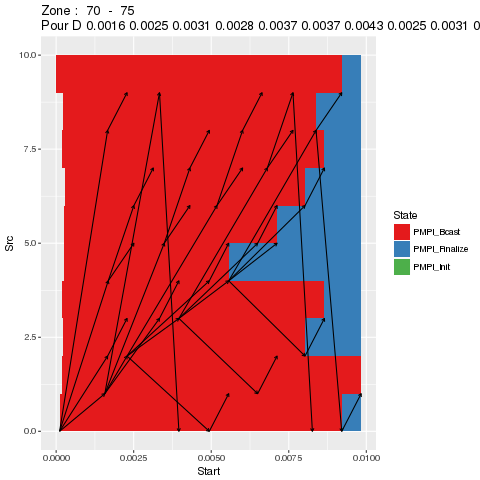

T_curr :  65
total execution time :  0.0726

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
merging : 0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0
****** SUCCESS : 2

  || RESULTS || 

T_curr :  75
total execution time :  0.08379999999999999

  || ANALYSIS || 

--------------------------------------------  ROUND :  11   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

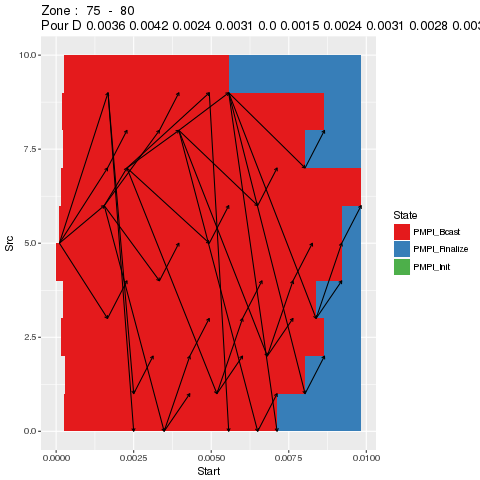

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 2 4 8 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 4 5 6 7 15 43 24 28 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.001487 0.001487    PMPI_Bcast
3     8 0.001487 0.004763 0.003276    PMPI_Bcast
4     8 0.004763 0.005846 0.001083    PMPI_Bcast
5     8 0.005846 0.007478 0.001632    PMPI_Bcast
6     8 0.007478 0.008228 0.000750    PMPI_Bcast
7     8 0.008228 0.009681 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.002940 0.002940    PMPI_Bcast
10    7 0.002940 0.004137 0.001197    PMPI_Bcast
11    7 0.004137 0.005846 0.001709    PMPI_Bcast
12    7 0.005846 0.006651 0.000805    PMPI_Bcast
13    7 0.006651 0.008502 0.001851    PMPI_Bcast
14    7 0.008502 0.009681 0.001179 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.002314 0.002314    PMPI_Bcast
17    6 0.002314 0.004137 0.001823    PMPI_Bcast
18    6 0.004137 0.005019 0.000882    PMPI_Bcast
19    6 0.005019 0.006972 0.001953    PMPI_Bcast
20    6 0.006972 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   0   1  0_1_-3334_4
2  0.000000 0.001487 0.001487   0   2  0_2_-3334_3
3  0.000000 0.001487 0.001487   0   4  0_4_-3334_2
4  0.000000 0.001487 0.001487   0   8  0_8_-3334_1
5  0.001487 0.002113 0.000626   1   2 1_2_-3334_12
6  0.001487 0.002113 0.000626   2   3  2_3_-3334_6
7  0.001487 0.002113 0.000626   8   9  8_9_-3334_8
8  0.001487 0.002314 0.000827   4   5 4_5_-3334_10
9  0.001487 0.002314 0.000827   4   6  4_6_-3334_7
10 0.002314 0.002940 0.000626   6   7 6_7_-3334_17
11 0.001487 0.003170 0.001683   1   9  1_9_-3334_5
12 0.001487 0.003170 0.001683   1   3 1_3_-3334_11
13 0.001487 0.003309 0.001822   1   5  1_5_-3334_9
14 0.002113 0.003796 0.001683   2   3 2_3_-3334_16
15 0.003170 0.003796 0.000626   3   4 3_4_-3334_19
16 0.003170 0.003796 0.000626   9   0 9_0_-3334_18
17 0.003309 0.004137 0.000828   5   6 5_6_-3334_21
18 0.003309 0.004137 0.000828   5   7 5_7_-3334_20
19 0.004137 0.004763 0.000626  

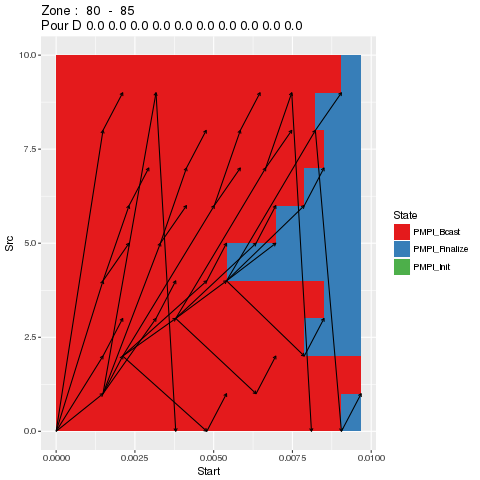

T_curr :  75
total execution time :  0.08379999999999999

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

T_curr :  80
total execution time :  0.08939999999999998

  || ANALYSIS || 

--------------------------------------------  ROUND :  12   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

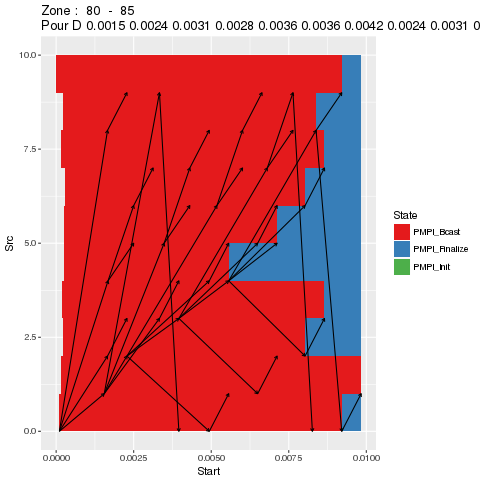

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002286 0.002090    PMPI_Bcast
3     8 0.002286 0.003332 0.001046    PMPI_Bcast
4     8 0.003332 0.003958 0.000626    PMPI_Bcast
5     8 0.003958 0.003958 0.000000    PMPI_Bcast
6     8 0.003958 0.008650 0.004692    PMPI_Bcast
7     8 0.008650 0.009834 0.001184 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001660 0.001443    PMPI_Bcast
10    7 0.001660 0.002286 0.000626    PMPI_Bcast
11    7 0.002286 0.002286 0.000000    PMPI_Bcast
12    7 0.002286 0.007123 0.004837    PMPI_Bcast
13    7 0.007123 0.008024 0.000901    PMPI_Bcast
14    7 0.008024 0.009834 0.001810 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000175 0.001569 0.001394    PMPI_Bcast
17    6 0.001569 0.001569 0.000000    PMPI_Bcast
18    6 0.001569 0.005564 0.003995    PMPI_Bcast
19    6 0.005564 0.006497 0.000933    PMPI_Bcast
20    6 0.006497 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   5   6  5_6_-3334_4
2  0.000112 0.001660 0.001548   5   7  5_7_-3334_3
3  0.000112 0.001660 0.001548   5   3  5_3_-3334_1
4  0.000112 0.001679 0.001567   5   9  5_9_-3334_2
5  0.001569 0.002286 0.000717   6   7  6_7_-3334_8
6  0.001660 0.002286 0.000626   3   4 3_4_-3334_10
7  0.001660 0.002286 0.000626   7   8  7_8_-3334_9
8  0.001679 0.002506 0.000827   9   0 9_0_-3334_12
9  0.001679 0.002506 0.000827   9   1 9_1_-3334_11
10 0.002506 0.003132 0.000626   1   2 1_2_-3334_17
11 0.001569 0.003332 0.001763   6   8  6_8_-3334_7
12 0.001569 0.003332 0.001763   6   4  6_4_-3334_5
13 0.001569 0.003486 0.001917   6   0  6_0_-3334_6
14 0.002286 0.003958 0.001672   7   8 7_8_-3334_16
15 0.003332 0.003958 0.000626   4   5 4_5_-3334_19
16 0.003332 0.003958 0.000626   8   9 8_9_-3334_18
17 0.003486 0.004313 0.000827   0   1 0_1_-3334_21
18 0.003486 0.004313 0.000827   0   2 0_2_-3334_20
19 0.002286 0.004938 0.002652  

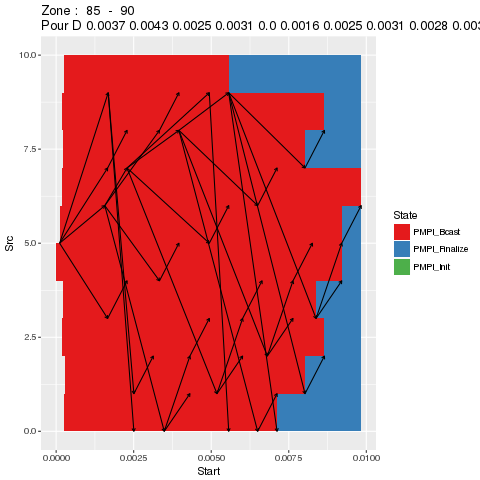

T_curr :  80
total execution time :  0.08939999999999998

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
merging : 0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
****** SUCCESS : 2

  || RESULTS || 

T_curr :  90
total execution time :  0.10059999999999997

  || ANALYSIS || 

--------------------------------------------  ROUND :  13   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

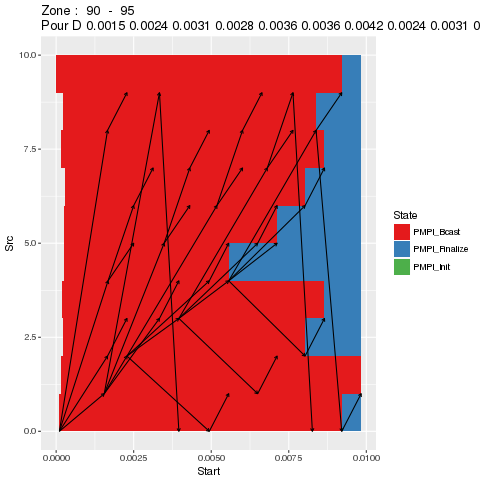

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  5 5 5 5 6 7 3 9 9 1 ...
 $ Dst     : num  6 7 9 3 7 8 4 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 22 17 25 32 13 39 43 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.002113 0.002113    PMPI_Bcast
3     8 0.002113 0.003170 0.001057    PMPI_Bcast
4     8 0.003170 0.003796 0.000626    PMPI_Bcast
5     8 0.003796 0.003796 0.000000    PMPI_Bcast
6     8 0.003796 0.008502 0.004706    PMPI_Bcast
7     8 0.008502 0.009681 0.001179 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.001487 0.001487    PMPI_Bcast
10    7 0.001487 0.002113 0.000626    PMPI_Bcast
11    7 0.002113 0.002113 0.000000    PMPI_Bcast
12    7 0.002113 0.006972 0.004859    PMPI_Bcast
13    7 0.006972 0.007876 0.000904    PMPI_Bcast
14    7 0.007876 0.009681 0.001805 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.001487 0.001487    PMPI_Bcast
17    6 0.001487 0.001487 0.000000    PMPI_Bcast
18    6 0.001487 0.005408 0.003921    PMPI_Bcast
19    6 0.005408 0.006346 0.000938    PMPI_Bcast
20    6 0.006346 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   5   6  5_6_-3334_4
2  0.000000 0.001487 0.001487   5   7  5_7_-3334_3
3  0.000000 0.001487 0.001487   5   9  5_9_-3334_2
4  0.000000 0.001487 0.001487   5   3  5_3_-3334_1
5  0.001487 0.002113 0.000626   6   7 6_7_-3334_12
6  0.001487 0.002113 0.000626   7   8  7_8_-3334_6
7  0.001487 0.002113 0.000626   3   4  3_4_-3334_8
8  0.001487 0.002314 0.000827   9   0 9_0_-3334_10
9  0.001487 0.002314 0.000827   9   1  9_1_-3334_7
10 0.002314 0.002940 0.000626   1   2 1_2_-3334_17
11 0.001487 0.003170 0.001683   6   4  6_4_-3334_5
12 0.001487 0.003170 0.001683   6   8 6_8_-3334_11
13 0.001487 0.003309 0.001822   6   0  6_0_-3334_9
14 0.002113 0.003796 0.001683   7   8 7_8_-3334_16
15 0.003170 0.003796 0.000626   8   9 8_9_-3334_19
16 0.003170 0.003796 0.000626   4   5 4_5_-3334_18
17 0.003309 0.004137 0.000828   0   1 0_1_-3334_21
18 0.003309 0.004137 0.000828   0   2 0_2_-3334_20
19 0.004137 0.004763 0.000626  

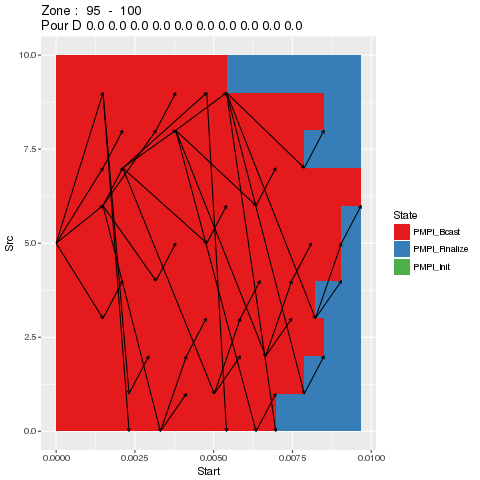

T_curr :  90
total execution time :  0.10059999999999997

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

T_curr :  95
total execution time :  0.10619999999999996

  || ANALYSIS || 

--------------------------------------------  ROUND :  14   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

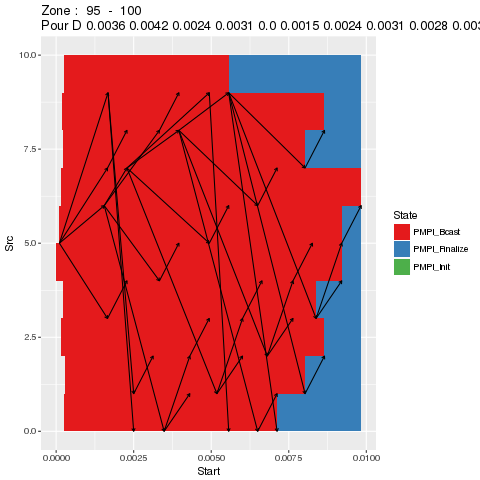

T_curr :  95
total execution time :  0.10619999999999996

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

T_curr :  100
total execution time :  0.11599999999999995

  || ANALYSIS || 

Total time : 0.11599999999999995
Success : True


In [39]:
NPROCS = 10
DEBUG = False
simulation(N, NPROCS, fragment_size, precision, mode, gap, catch_me)

In [33]:
%%R
mtcars

                     mpg cyl  disp  hp drat    wt  qsec vs am gear carb
Mazda RX4           21.0   6 160.0 110 3.90 2.620 16.46  0  1    4    4
Mazda RX4 Wag       21.0   6 160.0 110 3.90 2.875 17.02  0  1    4    4
Datsun 710          22.8   4 108.0  93 3.85 2.320 18.61  1  1    4    1
Hornet 4 Drive      21.4   6 258.0 110 3.08 3.215 19.44  1  0    3    1
Hornet Sportabout   18.7   8 360.0 175 3.15 3.440 17.02  0  0    3    2
Valiant             18.1   6 225.0 105 2.76 3.460 20.22  1  0    3    1
Duster 360          14.3   8 360.0 245 3.21 3.570 15.84  0  0    3    4
Merc 240D           24.4   4 146.7  62 3.69 3.190 20.00  1  0    4    2
Merc 230            22.8   4 140.8  95 3.92 3.150 22.90  1  0    4    2
Merc 280            19.2   6 167.6 123 3.92 3.440 18.30  1  0    4    4
Merc 280C           17.8   6 167.6 123 3.92 3.440 18.90  1  0    4    4
Merc 450SE          16.4   8 275.8 180 3.07 4.070 17.40  0  0    3    3
Merc 450SL          17.3   8 275.8 180 3.07 3.730 17.60  0  0   

In [30]:
def state_match(sim, t_curr, D_curr, gap, NPROCS):
#     print("Checking if state match : " + str(D_curr))
    merging = True
    number_of_keys = len(sim[t_curr])
        
    for index in range(number_of_keys):
        D = list(sim[t_curr].keys())[index]
        D = unformat_cmd(D)
        if type(D_curr) is str : D_curr = unformat_cmd(D_curr)
        merging = all(math.isclose(D_curr[i],D[i], abs_tol = gap) for i in range(NPROCS))
        if (merging) : D = format_cmd(D) ; print("merging : " + str(D)); return merging , D
    D_curr = format_cmd(D_curr)
    #print("returning: " + str(D_curr))
    return  merging , D_curr

#### Code de la simulation

In [31]:
# SIMULATION
import warnings
warnings.filterwarnings("ignore")
def simulation(N, NPROCS, fragment_size, precision, mode, gap, catch_me):
    
    """Contrôle de la validité des paramètres"""
    # Taille du fragment ne peut être supérieure à la zone d'itération
    if (fragment_size > N): 
        raise ValueError("Fragment size cannot be superior to N")
        
    """Mise en place de l'environnement et des variables"""
    # Environnement
    env_setup() 
    
    # Dates: pour la gestion de fichiers (IMPORTANT pour lecture/écriture)
    date_precise, date = date_setup()   
    
    # Temps d'exécution total
    total_execution_time = 0
    
    # Tableau de threads
    machines = init_tab(nodecount, None)
      
    # position trajectoire cohérente courante
    t_curr = 0
    
    # D de la trajectorie cohérente courante
    D_curr = format_cmd( init_tab( NPROCS, 0.0))

    fragment_number = int((math.ceil(N / fragment_size)))
    
    # zone d'itérations à explorer
    To_explore = collections.deque()
    
    # Initialisation des zones à explorer D = '0...0' pour chaque zone T -> (Min d'itération , D initial)
    for i in range(fragment_number):
        To_explore.append((i * fragment_size, format_cmd(init_tab(NPROCS, 0.0))))

    # Round actuel
    curr_round = 0
    
    # Liste des trajectoires pour un temps t et un D donnée
    sim = OrderedDict()
    
    # Vrai si un état final a fusionné avec un état initial au moins une fois
    success = False 
    
    if (mode == "SMART_GUESS"): reset_smart_table()
    
    catch_me_ind = 0
    
    while(True):
        curr_round = curr_round + 1
        
        # Zones restantes à explorer
        number_paths_To_explore = len(To_explore)
        # Trajectoire cohérente complète trouvé : FIN DE SIMULATION
        if (t_curr >= N) :
            cprint ("Total time : " + str(total_execution_time) , "grey" , "on_yellow")
            cprint ("Success : " + str(success) , "grey" , "on_green")
            break;        
        if (number_paths_To_explore  == 0):
            raise "No path to explore left !"
        # Il n'existe pas encore de trajectoire cohérente -> Nouveau round
        cprint("--------------------------------------------  ROUND :  " + str(curr_round) + "   --------------------------------------------\n","red", attrs=['reverse', 'blink'])
        

        
        # Nombre de tâches parallèles lançables
        number_launchable_tasks = min(nodecount, number_paths_To_explore)
        
        # Affichage des paramètres
        cprint ("  || LAUNCHING || \n","green", attrs=[ 'reverse', 'blink'])
        if (DEBUG): 
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value))
        
        """ Paramètrage des machines """
        
        # Soit j'ai plus de zone à explorer que de machines disponibles soit l'inverse
        for q in range(number_launchable_tasks):
            
            # On récupère la première zone à explorer
            parameters = To_explore.popleft()
            
            # MIN est le champ de gauche
            MIN = parameters[0]
            
            # MAX de la zone à explorer vaut le min + la taille du slot
            MAX = min (MIN + fragment_size, N)
            
            # D est le champ de droite
            delay = parameters[1]
            
            # Paramètrage des machines
            machines[q] = ParSimer(q, MIN, MAX, N, delay)
            #print("Machine " + str(q) + " -> MIN :" + str(MIN) + " MAX : " + str(MAX) + " D : "+ delay)   
                
        """ Simulation """  
        # Lancement de la simulation
        for q in range(number_launchable_tasks):
            machines[q].start()
            
        # Fin de simulation
        for q in range(number_launchable_tasks) :

            machines[q].join()
            filename = '~/experiments_src/Time_Bcast'
            get_results(date_precise, q)
            pj_dump(date, filename, q)
            get_csv(date, q)
            draw_ggplot(machines[q].get_MIN(), machines[q].get_MIN() + fragment_size , machines[q].get_delay())
            
          
        """ Analyse des résultats"""    
        # Traitement des données
        for q in range(number_launchable_tasks):
            # On récupère les paramètres des machines
            t = machines[q].get_MIN()
            D = machines[q].get_delay()
            
            # Calcul du délai
            # On récupère D et S
            raw_data = delayer(q, NPROCS, date_precise,precision)
            
            # Filtre D : Calcul du délai
            Dprime = format_cmd(raw_data[0])
            
            #Filte S : Calcul du temps d'éxécution total 
            T = raw_data[1]
            
            # Ajout dans ma table (Dprime, round, machine qui l'a calculé, temps)
            sim.setdefault(t,{}).update({D:(Dprime,curr_round,q,T)})
            MAX = min (t + fragment_size, N)
        
        # Affichage des paramètres
        print ( colored ("T_curr : " , "yellow") , str(t_curr))
        if (DEBUG) :
            print ( colored ("D_curr : " , "yellow") , str(D_curr))
            print ( colored ("Dprime : ", "yellow") , str(Dprime))
        print ( colored ("total execution time : ", "red") , str(total_execution_time) + "\n") 
        
        merged_paths = 0
        # Calcul de la trajectoire cohérente
        if(t_curr in sim) :
            merging , D_curr = state_match(sim, t_curr, D_curr, gap, NPROCS)
        while (t_curr < N and t_curr in sim and merging):
               #D_curr in sim[t_curr]):
            merged_paths += 1
            # Update le temps d'exécution
            total_execution_time += sim[t_curr][D_curr][3]
            
            # Update du temps d'exécution dans le dernier fragment
            if (t_curr + fragment_size >= N) : total_execution_time += max(unformat_cmd(sim[t_curr][D_curr][0]))
            
            # Update des t_curr et D_curr
            D_curr = sim[t_curr][D_curr][0]
            t_curr = min(t_curr + fragment_size, N)
            if (t_curr in sim):
                merging , D_curr = state_match(sim, t_curr, D_curr, gap, NPROCS)
        if (merged_paths > 1) : 
            cprint("****** SUCCESS : " + str(merged_paths), attrs=['reverse', 'bold'])
            success = True 
        
        # Affichage des résultats
        cprint ("\n  || RESULTS || \n","red", attrs=[ 'reverse', 'blink'])
        if (DEBUG):
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value)) 
            pretty (sim) 
        print ( colored ("T_curr : " , "yellow", attrs=[ 'bold']), str(t_curr))
        
        if (DEBUG):
            print ( colored ("D_curr : " , "yellow", attrs=[ 'bold']), str(D_curr))
            print ( colored ("Dprime : ", "yellow", attrs=[ 'bold']) , str(Dprime))
            
        print ( colored ("total execution time : ", "red", attrs=[ 'bold']) , str(total_execution_time) + "\n") 
        
        
        """ Nouveau paramètres """
        cprint("  || ANALYSIS || \n","magenta", attrs=[ 'reverse', 'blink'])
        while (To_explore and To_explore[0][0] <= t_curr):
            To_explore.popleft()
        
        for q in reversed(range(number_launchable_tasks)):
            t = machines[q].get_MIN()
            D = machines[q].get_delay()
            
            MAX = min(t + fragment_size, N)
            Dprime = sim[t][D][0]
           
            # Zone valide
            if(MAX < N):
                # Zone pas encore relié à la trajectoire initiale
                if (MAX > t_curr):
                    caught = False
                # Ajout dans les zones à explorer du nouveau point de départ à exploiter en fonction du mode
                    # Test catch me sur 2^catch_me_ind round
                    if (catch_me and 1 << catch_me_ind == curr_round):
                        catch_me_ind += 1
                        try :
                            caught = Dprime in sim[MAX]
                        except KeyError:
                            pass 
                       
                    if ((not catch_me or not caught) and mode != 'FIX'):
                        Dprime = generate_initial_state(mode, Dprime, t)
                        if (DEBUG) : print("["+str(MAX) +"] Generated " + str(mode) + " Dprime : " + str(Dprime))
                    # Mode fix implicite : append sans modification des valeurs MAX et Dprime    
                    To_explore.appendleft((MAX, Dprime))
        
        if (t_curr != N):
            To_explore.appendleft((t_curr, D_curr))
        if (DEBUG):
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value))
        

## SIMULATION

--------------------------------------------  ROUND :  1   --------------------------------------------

  || LAUNCHING || 

TO EXPLORE : 
0 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
5 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
10 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
graphene-6 => NPROCS = 7 MIN = 0 MAX = 5 N = 100 DELAY = '0.0 0.0 0.0 0.0 0.0 0.0 0.0'

graphene-62 => NPROCS = 7 MIN = 5 MAX = 10 N = 100 DELAY = '0.0 0.0 0.0 0.0 0.0 0.0 0.0'



'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0 0 0 0.00116 0.00116 ...
 $ End     : num  0.00116 0.00116 0.00116 0.00178 0.00178 ...
 $ Duration: num  0.001157 0.001157 0.001157 0.000626 0.000626 ...
 $ Src     : num  0 0 0 1 2 4 4 1 1 2 ...
 $ Dst     : num  1 2 4 2 3 5 6 3 5 3 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_27",..: 2 3 5 7 12 22 24 9 10 11 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.001984 0.001984    PMPI_Bcast
3     6 0.001984 0.003551 0.001567    PMPI_Bcast
4     6 0.003551 0.004201 0.000650    PMPI_Bcast
5     6 0.004201 0.005677 0.001476    PMPI_Bcast
6     6 0.005677 0.006303 0.000626    PMPI_Bcast
7     6 0.006303 0.007935 0.001632 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.001984 0.001984    PMPI_Bcast
10    5 0.001984 0.002723 0.000739    PMPI_Bcast
11    5 0.002723 0.004425 0.001702    PMPI_Bcast
12    5 0.004425 0.005051 0.000626    PMPI_Bcast
13    5 0.005051 0.005677 0.000626    PMPI_Bcast
14    5 0.005677 0.007935 0.002258 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.001157 0.001157    PMPI_Bcast
17    4 0.001157 0.003148 0.001991    PMPI_Bcast
18    4 0.003148 0.003799 0.000651    PMPI_Bcast
19    4 0.003799 0.004425 0.000626    PMPI_Bcast
20    4 0.004425 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001157 0.001157   0   1  0_1_-3334_3
2  0.000000 0.001157 0.001157   0   2  0_2_-3334_2
3  0.000000 0.001157 0.001157   0   4  0_4_-3334_1
4  0.001157 0.001783 0.000626   1   2  1_2_-3334_9
5  0.001157 0.001783 0.000626   2   3  2_3_-3334_5
6  0.001157 0.001984 0.000827   4   5  4_5_-3334_8
7  0.001157 0.001984 0.000827   4   6  4_6_-3334_6
8  0.001157 0.002522 0.001365   1   3  1_3_-3334_7
9  0.001157 0.002723 0.001566   1   5  1_5_-3334_4
10 0.001783 0.003148 0.001365   2   3 2_3_-3334_12
11 0.002522 0.003148 0.000626   3   4 3_4_-3334_13
12 0.002723 0.003551 0.000828   5   6 5_6_-3334_15
13 0.002723 0.003551 0.000828   5   0 5_0_-3334_14
14 0.001783 0.003799 0.002016   2   4 2_4_-3334_11
15 0.001783 0.004201 0.002418   2   6 2_6_-3334_10
16 0.003148 0.004425 0.001277   3   4 3_4_-3334_18
17 0.003799 0.004425 0.000626   4   5 4_5_-3334_19
18 0.004201 0.005028 0.000827   6   0 6_0_-3334_21
19 0.004201 0.005028 0.000827  

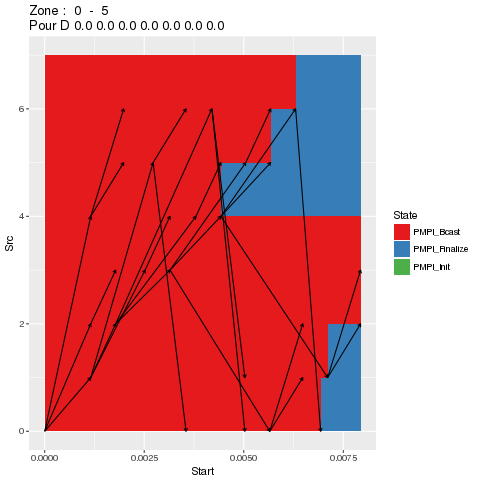

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0 0 0 0.00116 0.00116 ...
 $ End     : num  0.00116 0.00116 0.00116 0.00178 0.00178 ...
 $ Duration: num  0.001157 0.001157 0.001157 0.000626 0.000626 ...
 $ Src     : num  5 5 5 6 0 2 2 6 6 0 ...
 $ Dst     : num  6 0 2 0 1 3 4 1 3 1 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_12",..: 25 21 23 27 2 11 13 29 30 1 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.001157 0.001157    PMPI_Bcast
3     6 0.001157 0.001157 0.000000    PMPI_Bcast
4     6 0.001157 0.005028 0.003871    PMPI_Bcast
5     6 0.005028 0.006482 0.001454    PMPI_Bcast
6     6 0.006482 0.007108 0.000626    PMPI_Bcast
7     6 0.007108 0.007935 0.000827 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.000000 0.000000    PMPI_Bcast
10    5 0.000000 0.003551 0.003551    PMPI_Bcast
11    5 0.003551 0.005028 0.001477    PMPI_Bcast
12    5 0.005028 0.005654 0.000626    PMPI_Bcast
13    5 0.005654 0.006932 0.001278    PMPI_Bcast
14    5 0.006932 0.007935 0.001003 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.001984 0.001984    PMPI_Bcast
17    4 0.001984 0.003551 0.001567    PMPI_Bcast
18    4 0.003551 0.004201 0.000650    PMPI_Bcast
19    4 0.004201 0.005677 0.001476    PMPI_Bcast
20    4 0.005677 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001157 0.001157   5   6  5_6_-3334_3
2  0.000000 0.001157 0.001157   5   0  5_0_-3334_2
3  0.000000 0.001157 0.001157   5   2  5_2_-3334_1
4  0.001157 0.001783 0.000626   6   0  6_0_-3334_9
5  0.001157 0.001783 0.000626   0   1  0_1_-3334_5
6  0.001157 0.001984 0.000827   2   3  2_3_-3334_8
7  0.001157 0.001984 0.000827   2   4  2_4_-3334_6
8  0.001157 0.002522 0.001365   6   1  6_1_-3334_7
9  0.001157 0.002723 0.001566   6   3  6_3_-3334_4
10 0.001783 0.003148 0.001365   0   1 0_1_-3334_12
11 0.002522 0.003148 0.000626   1   2 1_2_-3334_13
12 0.002723 0.003551 0.000828   3   4 3_4_-3334_15
13 0.002723 0.003551 0.000828   3   5 3_5_-3334_14
14 0.001783 0.003799 0.002016   0   2 0_2_-3334_11
15 0.001783 0.004201 0.002418   0   4 0_4_-3334_10
16 0.003148 0.004425 0.001277   1   2 1_2_-3334_18
17 0.003799 0.004425 0.000626   2   3 2_3_-3334_19
18 0.004201 0.005028 0.000827   4   5 4_5_-3334_21
19 0.004201 0.005028 0.000827  

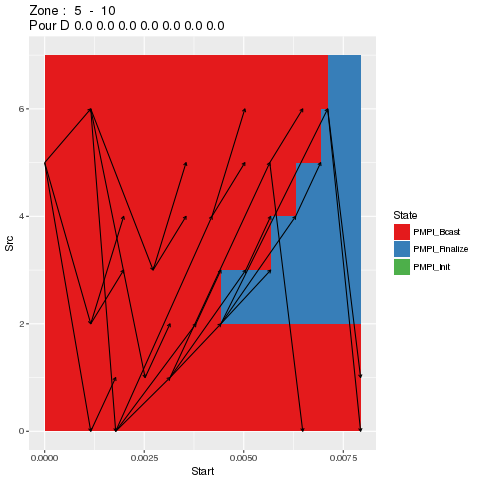

T_curr :  0
D_curr :  0.0 0.0 0.0 0.0 0.0 0.0 0.0
Dprime :  0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
total execution time :  0

merging : 0.0 0.0 0.0 0.0 0.0 0.0 0.0

  || RESULTS || 

TO EXPLORE : 
10 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000091 0.000091 0.000091 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001115 0.001176 0.001224 0.000687 0.000626 ...
 $ Src     : num  5 5 5 6 0 2 2 6 6 0 ...
 $ Dst     : num  6 0 2 0 1 3 4 1 3 1 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_12",..: 25 21 23 27 2 11 13 29 30 1 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000133 0.001206 0.001073    PMPI_Bcast
3     6 0.001206 0.001206 0.000000    PMPI_Bcast
4     6 0.001206 0.005144 0.003938    PMPI_Bcast
5     6 0.005144 0.006599 0.001455    PMPI_Bcast
6     6 0.006599 0.007225 0.000626    PMPI_Bcast
7     6 0.007225 0.008052 0.000827 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000091 0.000091 0.000000    PMPI_Bcast
10    5 0.000091 0.003687 0.003596    PMPI_Bcast
11    5 0.003687 0.005144 0.001457    PMPI_Bcast
12    5 0.005144 0.005770 0.000626    PMPI_Bcast
13    5 0.005770 0.007015 0.001245    PMPI_Bcast
14    5 0.007015 0.008052 0.001037 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.002143 0.002143    PMPI_Bcast
17    4 0.002143 0.003687 0.001544    PMPI_Bcast
18    4 0.003687 0.004317 0.000630    PMPI_Bcast
19    4 0.004317 0.005744 0.001427    PMPI_Bcast
20    4 0.005744 0.0

      Start      End Duration Src Dst           NA
1  0.000091 0.001206 0.001115   5   6  5_6_-3334_3
2  0.000091 0.001267 0.001176   5   0  5_0_-3334_2
3  0.000091 0.001315 0.001224   5   2  5_2_-3334_1
4  0.001206 0.001893 0.000687   6   0  6_0_-3334_6
5  0.001267 0.001893 0.000626   0   1  0_1_-3334_7
6  0.001315 0.002143 0.000828   2   3  2_3_-3334_9
7  0.001315 0.002143 0.000828   2   4  2_4_-3334_8
8  0.001206 0.002610 0.001404   6   1  6_1_-3334_5
9  0.001206 0.002860 0.001654   6   3  6_3_-3334_4
10 0.001893 0.003236 0.001343   0   1 0_1_-3334_12
11 0.002610 0.003236 0.000626   1   2 1_2_-3334_13
12 0.002860 0.003687 0.000827   3   4 3_4_-3334_15
13 0.002860 0.003687 0.000827   3   5 3_5_-3334_14
14 0.001893 0.003866 0.001973   0   2 0_2_-3334_11
15 0.001893 0.004317 0.002424   0   4 0_4_-3334_10
16 0.003236 0.004492 0.001256   1   2 1_2_-3334_18
17 0.003866 0.004492 0.000626   2   3 2_3_-3334_19
18 0.003236 0.005118 0.001882   1   3 1_3_-3334_17
19 0.004317 0.005144 0.000827  

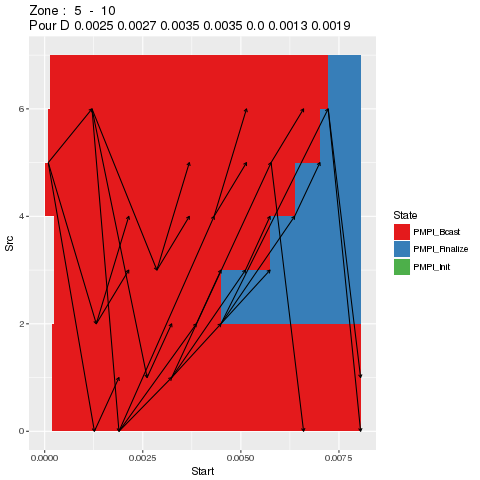

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000091 0.000091 0.000091 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001115 0.001176 0.001224 0.000687 0.000626 ...
 $ Src     : num  3 3 3 4 5 0 0 4 4 5 ...
 $ Dst     : num  4 5 0 5 6 1 2 6 1 6 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_19",..: 15 16 13 20 26 3 5 22 18 25 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000189 0.001893 0.001704    PMPI_Bcast
3     6 0.001893 0.002610 0.000717    PMPI_Bcast
4     6 0.002610 0.003236 0.000626    PMPI_Bcast
5     6 0.003236 0.003236 0.000000    PMPI_Bcast
6     6 0.003236 0.008052 0.004816    PMPI_Bcast
7     6 0.008052 0.008052 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000175 0.001267 0.001092    PMPI_Bcast
10    5 0.001267 0.001893 0.000626    PMPI_Bcast
11    5 0.001893 0.001893 0.000000    PMPI_Bcast
12    5 0.001893 0.006599 0.004706    PMPI_Bcast
13    5 0.006599 0.008052 0.001453    PMPI_Bcast
14    5 0.008052 0.008052 0.000000 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000133 0.001206 0.001073    PMPI_Bcast
17    4 0.001206 0.001206 0.000000    PMPI_Bcast
18    4 0.001206 0.005144 0.003938    PMPI_Bcast
19    4 0.005144 0.006599 0.001455    PMPI_Bcast
20    4 0.006599 0.0

      Start      End Duration Src Dst           NA
1  0.000091 0.001206 0.001115   3   4  3_4_-3334_3
2  0.000091 0.001267 0.001176   3   5  3_5_-3334_2
3  0.000091 0.001315 0.001224   3   0  3_0_-3334_1
4  0.001206 0.001893 0.000687   4   5  4_5_-3334_6
5  0.001267 0.001893 0.000626   5   6  5_6_-3334_7
6  0.001315 0.002143 0.000828   0   1  0_1_-3334_9
7  0.001315 0.002143 0.000828   0   2  0_2_-3334_8
8  0.001206 0.002610 0.001404   4   6  4_6_-3334_5
9  0.001206 0.002860 0.001654   4   1  4_1_-3334_4
10 0.001893 0.003236 0.001343   5   6 5_6_-3334_12
11 0.002610 0.003236 0.000626   6   0 6_0_-3334_13
12 0.002860 0.003687 0.000827   1   2 1_2_-3334_15
13 0.002860 0.003687 0.000827   1   3 1_3_-3334_14
14 0.001893 0.003866 0.001973   5   0 5_0_-3334_11
15 0.001893 0.004317 0.002424   5   2 5_2_-3334_10
16 0.003236 0.004492 0.001256   6   0 6_0_-3334_18
17 0.003866 0.004492 0.000626   0   1 0_1_-3334_19
18 0.003236 0.005118 0.001882   6   1 6_1_-3334_17
19 0.004317 0.005144 0.000827  

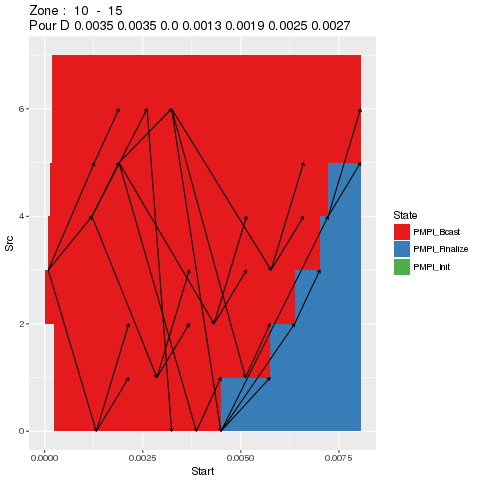

T_curr :  5
D_curr :  0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
Dprime :  0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036
total execution time :  0.0044

merging : 0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
merging : 0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
****** SUCCESS : 2

  || RESULTS || 

TO EXPLORE : 
10 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001203 0.001263 ...
 $ End     : num  0.0012 0.00126 0.00132 0.00189 0.00189 ...
 $ Duration: num  0.001119 0.001179 0.001233 0.000686 0.000626 ...
 $ Src     : num  1 1 1 2 3 5 5 2 2 3 ...
 $ Dst     : num  2 3 5 3 4 6 0 4 6 4 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_21",..: 5 6 8 10 16 27 23 12 13 15 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000252 0.002144 0.001892    PMPI_Bcast
3     6 0.002144 0.002859 0.000715    PMPI_Bcast
4     6 0.002859 0.004484 0.001625    PMPI_Bcast
5     6 0.004484 0.005110 0.000626    PMPI_Bcast
6     6 0.005110 0.005736 0.000626    PMPI_Bcast
7     6 0.005736 0.008049 0.002313 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000252 0.001317 0.001065    PMPI_Bcast
10    5 0.001317 0.003231 0.001914    PMPI_Bcast
11    5 0.003231 0.003858 0.000627    PMPI_Bcast
12    5 0.003858 0.004484 0.000626    PMPI_Bcast
13    5 0.004484 0.004484 0.000000    PMPI_Bcast
14    5 0.004484 0.008049 0.003565 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000189 0.001889 0.001700    PMPI_Bcast
17    4 0.001889 0.002605 0.000716    PMPI_Bcast
18    4 0.002605 0.003231 0.000626    PMPI_Bcast
19    4 0.003231 0.003231 0.000000    PMPI_Bcast
20    4 0.003231 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001203 0.001119   1   2  1_2_-3334_3
2  0.000084 0.001263 0.001179   1   3  1_3_-3334_2
3  0.000084 0.001317 0.001233   1   5  1_5_-3334_1
4  0.001203 0.001889 0.000686   2   3  2_3_-3334_6
5  0.001263 0.001889 0.000626   3   4  3_4_-3334_7
6  0.001317 0.002144 0.000827   5   6  5_6_-3334_9
7  0.001317 0.002144 0.000827   5   0  5_0_-3334_8
8  0.001203 0.002605 0.001402   2   4  2_4_-3334_5
9  0.001203 0.002859 0.001656   2   6  2_6_-3334_4
10 0.001889 0.003231 0.001342   3   4 3_4_-3334_12
11 0.002605 0.003231 0.000626   4   5 4_5_-3334_13
12 0.002859 0.003687 0.000828   6   0 6_0_-3334_15
13 0.002859 0.003687 0.000828   6   1 6_1_-3334_14
14 0.001889 0.003858 0.001969   3   5 3_5_-3334_11
15 0.001889 0.004314 0.002425   3   0 3_0_-3334_10
16 0.003231 0.004484 0.001253   4   5 4_5_-3334_18
17 0.003858 0.004484 0.000626   5   6 5_6_-3334_19
18 0.003231 0.005110 0.001879   4   6 4_6_-3334_17
19 0.004314 0.005141 0.000827  

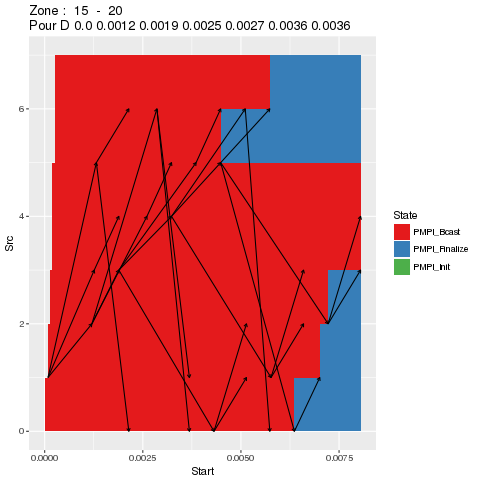

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0 0 0 0.00116 0.00116 ...
 $ End     : num  0.00116 0.00116 0.00116 0.00178 0.00178 ...
 $ Duration: num  0.001157 0.001157 0.001157 0.000626 0.000626 ...
 $ Src     : num  6 6 6 0 1 3 3 0 0 1 ...
 $ Dst     : num  0 1 3 1 2 4 5 2 4 2 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_30",..: 27 28 30 2 7 17 19 4 5 6 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.000000 0.000000    PMPI_Bcast
3     6 0.000000 0.003551 0.003551    PMPI_Bcast
4     6 0.003551 0.005028 0.001477    PMPI_Bcast
5     6 0.005028 0.005654 0.000626    PMPI_Bcast
6     6 0.005654 0.006932 0.001278    PMPI_Bcast
7     6 0.006932 0.007935 0.001003 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.001984 0.001984    PMPI_Bcast
10    5 0.001984 0.003551 0.001567    PMPI_Bcast
11    5 0.003551 0.004201 0.000650    PMPI_Bcast
12    5 0.004201 0.005677 0.001476    PMPI_Bcast
13    5 0.005677 0.006303 0.000626    PMPI_Bcast
14    5 0.006303 0.007935 0.001632 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.001984 0.001984    PMPI_Bcast
17    4 0.001984 0.002723 0.000739    PMPI_Bcast
18    4 0.002723 0.004425 0.001702    PMPI_Bcast
19    4 0.004425 0.005051 0.000626    PMPI_Bcast
20    4 0.005051 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001157 0.001157   6   0  6_0_-3334_3
2  0.000000 0.001157 0.001157   6   1  6_1_-3334_2
3  0.000000 0.001157 0.001157   6   3  6_3_-3334_1
4  0.001157 0.001783 0.000626   0   1  0_1_-3334_9
5  0.001157 0.001783 0.000626   1   2  1_2_-3334_5
6  0.001157 0.001984 0.000827   3   4  3_4_-3334_8
7  0.001157 0.001984 0.000827   3   5  3_5_-3334_6
8  0.001157 0.002522 0.001365   0   2  0_2_-3334_7
9  0.001157 0.002723 0.001566   0   4  0_4_-3334_4
10 0.001783 0.003148 0.001365   1   2 1_2_-3334_12
11 0.002522 0.003148 0.000626   2   3 2_3_-3334_13
12 0.002723 0.003551 0.000828   4   5 4_5_-3334_15
13 0.002723 0.003551 0.000828   4   6 4_6_-3334_14
14 0.001783 0.003799 0.002016   1   3 1_3_-3334_11
15 0.001783 0.004201 0.002418   1   5 1_5_-3334_10
16 0.003148 0.004425 0.001277   2   3 2_3_-3334_18
17 0.003799 0.004425 0.000626   3   4 3_4_-3334_19
18 0.004201 0.005028 0.000827   5   6 5_6_-3334_21
19 0.004201 0.005028 0.000827  

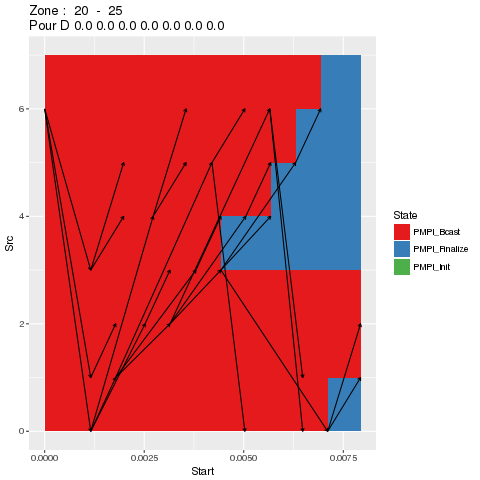

T_curr :  15
D_curr :  0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036
Dprime :  0.0027 0.0035 0.0035 0.0 0.0013 0.0019 0.0025
total execution time :  0.013399999999999999

merging : 0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036

  || RESULTS || 

TO EXPLORE : 
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001122 0.001183 0.001231 0.000687 0.000626 ...
 $ Src     : num  6 6 6 0 1 3 3 0 0 1 ...
 $ Dst     : num  0 1 3 1 2 4 5 2 4 2 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_30",..: 27 28 30 2 7 17 19 4 5 6 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000084 0.000084 0.000000    PMPI_Bcast
3     6 0.000084 0.003687 0.003603    PMPI_Bcast
4     6 0.003687 0.005144 0.001457    PMPI_Bcast
5     6 0.005144 0.005770 0.000626    PMPI_Bcast
6     6 0.005770 0.007015 0.001245    PMPI_Bcast
7     6 0.007015 0.008052 0.001037 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.002143 0.002143    PMPI_Bcast
10    5 0.002143 0.003687 0.001544    PMPI_Bcast
11    5 0.003687 0.004317 0.000630    PMPI_Bcast
12    5 0.004317 0.005744 0.001427    PMPI_Bcast
13    5 0.005744 0.006370 0.000626    PMPI_Bcast
14    5 0.006370 0.008052 0.001682 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000245 0.002143 0.001898    PMPI_Bcast
17    4 0.002143 0.002860 0.000717    PMPI_Bcast
18    4 0.002860 0.004492 0.001632    PMPI_Bcast
19    4 0.004492 0.005118 0.000626    PMPI_Bcast
20    4 0.005118 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001206 0.001122   6   0  6_0_-3334_3
2  0.000084 0.001267 0.001183   6   1  6_1_-3334_2
3  0.000084 0.001315 0.001231   6   3  6_3_-3334_1
4  0.001206 0.001893 0.000687   0   1  0_1_-3334_6
5  0.001267 0.001893 0.000626   1   2  1_2_-3334_7
6  0.001315 0.002143 0.000828   3   4  3_4_-3334_9
7  0.001315 0.002143 0.000828   3   5  3_5_-3334_8
8  0.001206 0.002610 0.001404   0   2  0_2_-3334_5
9  0.001206 0.002860 0.001654   0   4  0_4_-3334_4
10 0.001893 0.003236 0.001343   1   2 1_2_-3334_12
11 0.002610 0.003236 0.000626   2   3 2_3_-3334_13
12 0.002860 0.003687 0.000827   4   5 4_5_-3334_15
13 0.002860 0.003687 0.000827   4   6 4_6_-3334_14
14 0.001893 0.003866 0.001973   1   3 1_3_-3334_11
15 0.001893 0.004317 0.002424   1   5 1_5_-3334_10
16 0.003236 0.004492 0.001256   2   3 2_3_-3334_18
17 0.003866 0.004492 0.000626   3   4 3_4_-3334_19
18 0.003236 0.005118 0.001882   2   4 2_4_-3334_17
19 0.004317 0.005144 0.000827  

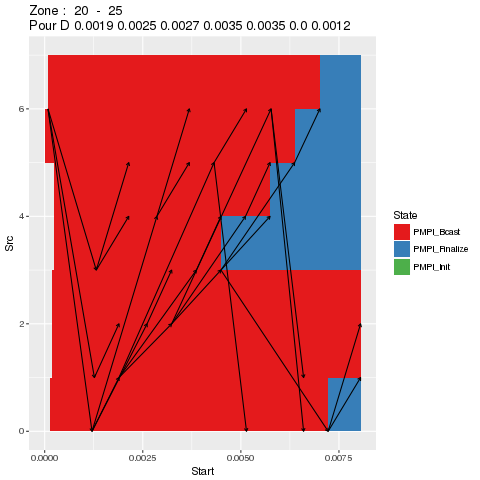

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000091 0.000091 0.000091 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001115 0.001176 0.001224 0.000687 0.000626 ...
 $ Src     : num  4 4 4 5 6 1 1 5 5 6 ...
 $ Dst     : num  5 6 1 6 0 2 3 0 2 0 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_13",..: 19 20 17 26 28 7 9 23 24 27 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000175 0.001267 0.001092    PMPI_Bcast
3     6 0.001267 0.001893 0.000626    PMPI_Bcast
4     6 0.001893 0.001893 0.000000    PMPI_Bcast
5     6 0.001893 0.006599 0.004706    PMPI_Bcast
6     6 0.006599 0.008052 0.001453    PMPI_Bcast
7     6 0.008052 0.008052 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000133 0.001206 0.001073    PMPI_Bcast
10    5 0.001206 0.001206 0.000000    PMPI_Bcast
11    5 0.001206 0.005144 0.003938    PMPI_Bcast
12    5 0.005144 0.006599 0.001455    PMPI_Bcast
13    5 0.006599 0.007225 0.000626    PMPI_Bcast
14    5 0.007225 0.008052 0.000827 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000091 0.000091 0.000000    PMPI_Bcast
17    4 0.000091 0.003687 0.003596    PMPI_Bcast
18    4 0.003687 0.005144 0.001457    PMPI_Bcast
19    4 0.005144 0.005770 0.000626    PMPI_Bcast
20    4 0.005770 0.0

      Start      End Duration Src Dst           NA
1  0.000091 0.001206 0.001115   4   5  4_5_-3334_3
2  0.000091 0.001267 0.001176   4   6  4_6_-3334_2
3  0.000091 0.001315 0.001224   4   1  4_1_-3334_1
4  0.001206 0.001893 0.000687   5   6  5_6_-3334_6
5  0.001267 0.001893 0.000626   6   0  6_0_-3334_7
6  0.001315 0.002143 0.000828   1   2  1_2_-3334_9
7  0.001315 0.002143 0.000828   1   3  1_3_-3334_8
8  0.001206 0.002610 0.001404   5   0  5_0_-3334_5
9  0.001206 0.002860 0.001654   5   2  5_2_-3334_4
10 0.001893 0.003236 0.001343   6   0 6_0_-3334_12
11 0.002610 0.003236 0.000626   0   1 0_1_-3334_13
12 0.002860 0.003687 0.000827   2   3 2_3_-3334_15
13 0.002860 0.003687 0.000827   2   4 2_4_-3334_14
14 0.001893 0.003866 0.001973   6   1 6_1_-3334_11
15 0.001893 0.004317 0.002424   6   3 6_3_-3334_10
16 0.003236 0.004492 0.001256   0   1 0_1_-3334_18
17 0.003866 0.004492 0.000626   1   2 1_2_-3334_19
18 0.003236 0.005118 0.001882   0   2 0_2_-3334_17
19 0.004317 0.005144 0.000827  

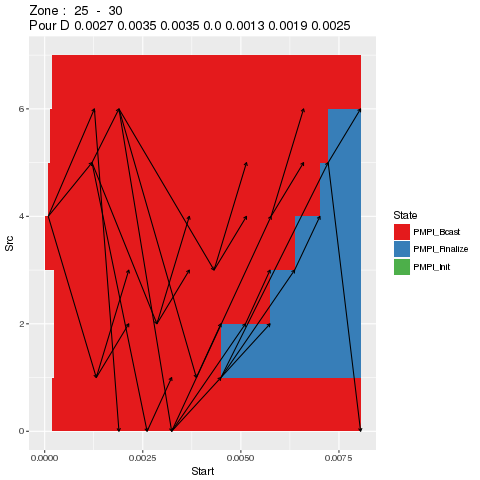

T_curr :  20
D_curr :  0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0012
Dprime :  0.0036 0.0 0.0012 0.0019 0.0025 0.0027 0.0036
total execution time :  0.0179

merging : 0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0012
merging : 0.0027 0.0035 0.0035 0.0 0.0013 0.0019 0.0025
****** SUCCESS : 2

  || RESULTS || 

TO EXPLORE : 
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.002

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001203 0.001263 ...
 $ End     : num  0.0012 0.00126 0.00132 0.00189 0.00189 ...
 $ Duration: num  0.001119 0.001179 0.001233 0.000686 0.000626 ...
 $ Src     : num  2 2 2 3 4 6 6 3 3 4 ...
 $ Dst     : num  3 4 6 4 5 0 1 5 0 5 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_15",..: 8 9 11 14 19 27 29 16 12 18 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000252 0.001317 0.001065    PMPI_Bcast
3     6 0.001317 0.003231 0.001914    PMPI_Bcast
4     6 0.003231 0.003858 0.000627    PMPI_Bcast
5     6 0.003858 0.004484 0.000626    PMPI_Bcast
6     6 0.004484 0.004484 0.000000    PMPI_Bcast
7     6 0.004484 0.008049 0.003565 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000189 0.001889 0.001700    PMPI_Bcast
10    5 0.001889 0.002605 0.000716    PMPI_Bcast
11    5 0.002605 0.003231 0.000626    PMPI_Bcast
12    5 0.003231 0.003231 0.000000    PMPI_Bcast
13    5 0.003231 0.008049 0.004818    PMPI_Bcast
14    5 0.008049 0.008049 0.000000 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000175 0.001263 0.001088    PMPI_Bcast
17    4 0.001263 0.001889 0.000626    PMPI_Bcast
18    4 0.001889 0.001889 0.000000    PMPI_Bcast
19    4 0.001889 0.006596 0.004707    PMPI_Bcast
20    4 0.006596 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001203 0.001119   2   3  2_3_-3334_3
2  0.000084 0.001263 0.001179   2   4  2_4_-3334_2
3  0.000084 0.001317 0.001233   2   6  2_6_-3334_1
4  0.001203 0.001889 0.000686   3   4  3_4_-3334_6
5  0.001263 0.001889 0.000626   4   5  4_5_-3334_7
6  0.001317 0.002144 0.000827   6   0  6_0_-3334_9
7  0.001317 0.002144 0.000827   6   1  6_1_-3334_8
8  0.001203 0.002605 0.001402   3   5  3_5_-3334_5
9  0.001203 0.002859 0.001656   3   0  3_0_-3334_4
10 0.001889 0.003231 0.001342   4   5 4_5_-3334_12
11 0.002605 0.003231 0.000626   5   6 5_6_-3334_13
12 0.002859 0.003687 0.000828   0   1 0_1_-3334_15
13 0.002859 0.003687 0.000828   0   2 0_2_-3334_14
14 0.001889 0.003858 0.001969   4   6 4_6_-3334_11
15 0.001889 0.004314 0.002425   4   1 4_1_-3334_10
16 0.003231 0.004484 0.001253   5   6 5_6_-3334_18
17 0.003858 0.004484 0.000626   6   0 6_0_-3334_19
18 0.003231 0.005110 0.001879   5   0 5_0_-3334_17
19 0.004314 0.005141 0.000827  

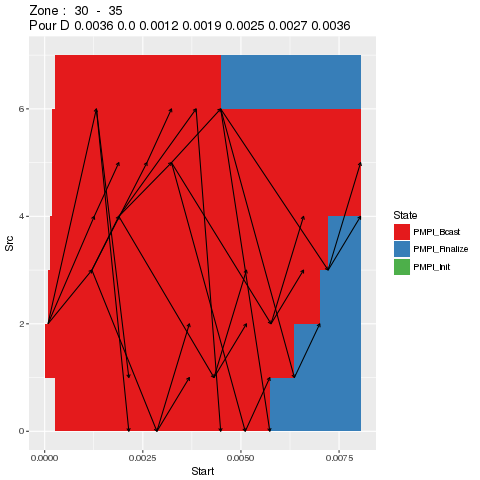

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0 0 0 0.00116 0.00116 ...
 $ End     : num  0.00116 0.00116 0.00116 0.00178 0.00178 ...
 $ Duration: num  0.001157 0.001157 0.001157 0.000626 0.000626 ...
 $ Src     : num  0 0 0 1 2 4 4 1 1 2 ...
 $ Dst     : num  1 2 4 2 3 5 6 3 5 3 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_27",..: 2 3 5 7 12 22 24 9 10 11 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.001984 0.001984    PMPI_Bcast
3     6 0.001984 0.003551 0.001567    PMPI_Bcast
4     6 0.003551 0.004201 0.000650    PMPI_Bcast
5     6 0.004201 0.005677 0.001476    PMPI_Bcast
6     6 0.005677 0.006303 0.000626    PMPI_Bcast
7     6 0.006303 0.007935 0.001632 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.001984 0.001984    PMPI_Bcast
10    5 0.001984 0.002723 0.000739    PMPI_Bcast
11    5 0.002723 0.004425 0.001702    PMPI_Bcast
12    5 0.004425 0.005051 0.000626    PMPI_Bcast
13    5 0.005051 0.005677 0.000626    PMPI_Bcast
14    5 0.005677 0.007935 0.002258 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.001157 0.001157    PMPI_Bcast
17    4 0.001157 0.003148 0.001991    PMPI_Bcast
18    4 0.003148 0.003799 0.000651    PMPI_Bcast
19    4 0.003799 0.004425 0.000626    PMPI_Bcast
20    4 0.004425 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001157 0.001157   0   1  0_1_-3334_3
2  0.000000 0.001157 0.001157   0   2  0_2_-3334_2
3  0.000000 0.001157 0.001157   0   4  0_4_-3334_1
4  0.001157 0.001783 0.000626   1   2  1_2_-3334_9
5  0.001157 0.001783 0.000626   2   3  2_3_-3334_5
6  0.001157 0.001984 0.000827   4   5  4_5_-3334_8
7  0.001157 0.001984 0.000827   4   6  4_6_-3334_6
8  0.001157 0.002522 0.001365   1   3  1_3_-3334_7
9  0.001157 0.002723 0.001566   1   5  1_5_-3334_4
10 0.001783 0.003148 0.001365   2   3 2_3_-3334_12
11 0.002522 0.003148 0.000626   3   4 3_4_-3334_13
12 0.002723 0.003551 0.000828   5   6 5_6_-3334_15
13 0.002723 0.003551 0.000828   5   0 5_0_-3334_14
14 0.001783 0.003799 0.002016   2   4 2_4_-3334_11
15 0.001783 0.004201 0.002418   2   6 2_6_-3334_10
16 0.003148 0.004425 0.001277   3   4 3_4_-3334_18
17 0.003799 0.004425 0.000626   4   5 4_5_-3334_19
18 0.004201 0.005028 0.000827   6   0 6_0_-3334_21
19 0.004201 0.005028 0.000827  

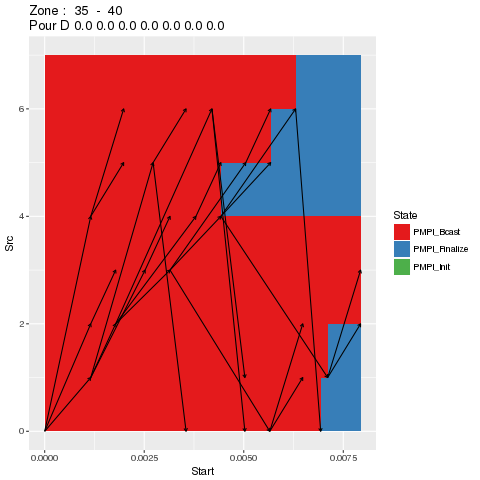

T_curr :  30
D_curr :  0.0036 0.0 0.0012 0.0019 0.0025 0.0027 0.0036
Dprime :  0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
total execution time :  0.0269

merging : 0.0036 0.0 0.0012 0.0019 0.0025 0.0027 0.0036

  || RESULTS || 

TO EXPLORE : 
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027', 2, 0, 0.0045)
10
	0.0035 0.0035 0.0 0.0013 0.0019 0.0

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001122 0.001183 0.001231 0.000687 0.000626 ...
 $ Src     : num  0 0 0 1 2 4 4 1 1 2 ...
 $ Dst     : num  1 2 4 2 3 5 6 3 5 3 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_27",..: 2 3 5 7 12 22 24 9 10 11 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.002143 0.002143    PMPI_Bcast
3     6 0.002143 0.003687 0.001544    PMPI_Bcast
4     6 0.003687 0.004317 0.000630    PMPI_Bcast
5     6 0.004317 0.005744 0.001427    PMPI_Bcast
6     6 0.005744 0.006370 0.000626    PMPI_Bcast
7     6 0.006370 0.008052 0.001682 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000245 0.002143 0.001898    PMPI_Bcast
10    5 0.002143 0.002860 0.000717    PMPI_Bcast
11    5 0.002860 0.004492 0.001632    PMPI_Bcast
12    5 0.004492 0.005118 0.000626    PMPI_Bcast
13    5 0.005118 0.005744 0.000626    PMPI_Bcast
14    5 0.005744 0.008052 0.002308 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000245 0.001315 0.001070    PMPI_Bcast
17    4 0.001315 0.003236 0.001921    PMPI_Bcast
18    4 0.003236 0.003866 0.000630    PMPI_Bcast
19    4 0.003866 0.004492 0.000626    PMPI_Bcast
20    4 0.004492 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001206 0.001122   0   1  0_1_-3334_3
2  0.000084 0.001267 0.001183   0   2  0_2_-3334_2
3  0.000084 0.001315 0.001231   0   4  0_4_-3334_1
4  0.001206 0.001893 0.000687   1   2  1_2_-3334_6
5  0.001267 0.001893 0.000626   2   3  2_3_-3334_7
6  0.001315 0.002143 0.000828   4   5  4_5_-3334_9
7  0.001315 0.002143 0.000828   4   6  4_6_-3334_8
8  0.001206 0.002610 0.001404   1   3  1_3_-3334_5
9  0.001206 0.002860 0.001654   1   5  1_5_-3334_4
10 0.001893 0.003236 0.001343   2   3 2_3_-3334_12
11 0.002610 0.003236 0.000626   3   4 3_4_-3334_13
12 0.002860 0.003687 0.000827   5   6 5_6_-3334_15
13 0.002860 0.003687 0.000827   5   0 5_0_-3334_14
14 0.001893 0.003866 0.001973   2   4 2_4_-3334_11
15 0.001893 0.004317 0.002424   2   6 2_6_-3334_10
16 0.003236 0.004492 0.001256   3   4 3_4_-3334_18
17 0.003866 0.004492 0.000626   4   5 4_5_-3334_19
18 0.003236 0.005118 0.001882   3   5 3_5_-3334_17
19 0.004317 0.005144 0.000827  

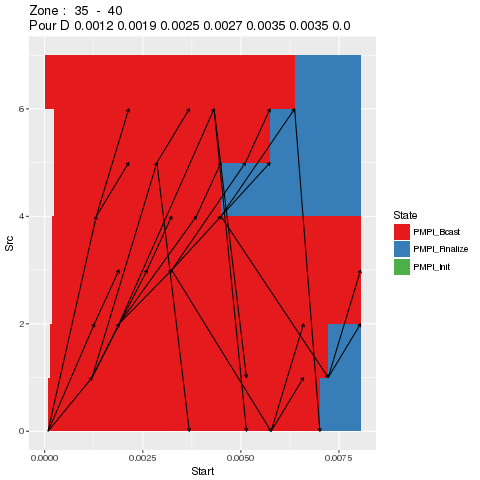

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000091 0.000091 0.000091 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001115 0.001176 0.001224 0.000687 0.000626 ...
 $ Src     : num  5 5 5 6 0 2 2 6 6 0 ...
 $ Dst     : num  6 0 2 0 1 3 4 1 3 1 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_12",..: 25 21 23 27 2 11 13 29 30 1 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000133 0.001206 0.001073    PMPI_Bcast
3     6 0.001206 0.001206 0.000000    PMPI_Bcast
4     6 0.001206 0.005144 0.003938    PMPI_Bcast
5     6 0.005144 0.006599 0.001455    PMPI_Bcast
6     6 0.006599 0.007225 0.000626    PMPI_Bcast
7     6 0.007225 0.008052 0.000827 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000091 0.000091 0.000000    PMPI_Bcast
10    5 0.000091 0.003687 0.003596    PMPI_Bcast
11    5 0.003687 0.005144 0.001457    PMPI_Bcast
12    5 0.005144 0.005770 0.000626    PMPI_Bcast
13    5 0.005770 0.007015 0.001245    PMPI_Bcast
14    5 0.007015 0.008052 0.001037 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.002143 0.002143    PMPI_Bcast
17    4 0.002143 0.003687 0.001544    PMPI_Bcast
18    4 0.003687 0.004317 0.000630    PMPI_Bcast
19    4 0.004317 0.005744 0.001427    PMPI_Bcast
20    4 0.005744 0.0

      Start      End Duration Src Dst           NA
1  0.000091 0.001206 0.001115   5   6  5_6_-3334_3
2  0.000091 0.001267 0.001176   5   0  5_0_-3334_2
3  0.000091 0.001315 0.001224   5   2  5_2_-3334_1
4  0.001206 0.001893 0.000687   6   0  6_0_-3334_6
5  0.001267 0.001893 0.000626   0   1  0_1_-3334_7
6  0.001315 0.002143 0.000828   2   3  2_3_-3334_9
7  0.001315 0.002143 0.000828   2   4  2_4_-3334_8
8  0.001206 0.002610 0.001404   6   1  6_1_-3334_5
9  0.001206 0.002860 0.001654   6   3  6_3_-3334_4
10 0.001893 0.003236 0.001343   0   1 0_1_-3334_12
11 0.002610 0.003236 0.000626   1   2 1_2_-3334_13
12 0.002860 0.003687 0.000827   3   4 3_4_-3334_15
13 0.002860 0.003687 0.000827   3   5 3_5_-3334_14
14 0.001893 0.003866 0.001973   0   2 0_2_-3334_11
15 0.001893 0.004317 0.002424   0   4 0_4_-3334_10
16 0.003236 0.004492 0.001256   1   2 1_2_-3334_18
17 0.003866 0.004492 0.000626   2   3 2_3_-3334_19
18 0.003236 0.005118 0.001882   1   3 1_3_-3334_17
19 0.004317 0.005144 0.000827  

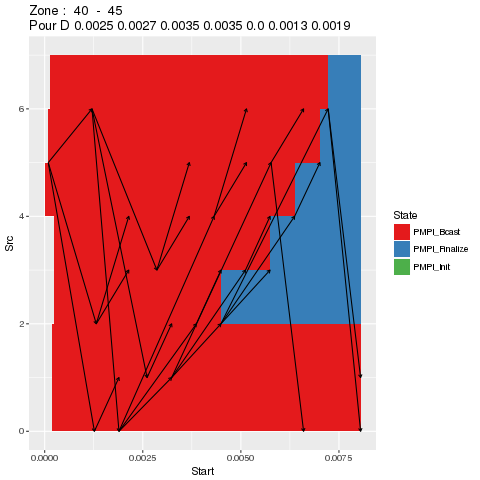

T_curr :  35
D_curr :  0.0012 0.0019 0.0025 0.0027 0.0035 0.0035 0.0
Dprime :  0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027
total execution time :  0.0314

merging : 0.0012 0.0019 0.0025 0.0027 0.0035 0.0035 0.0
merging : 0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
****** SUCCESS : 2

  || RESULTS || 

TO EXPLORE : 
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0036 0.0036 0.0 0.0012 0

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001203 0.001263 ...
 $ End     : num  0.0012 0.00126 0.00132 0.00189 0.00189 ...
 $ Duration: num  0.001119 0.001179 0.001233 0.000686 0.000626 ...
 $ Src     : num  3 3 3 4 5 0 0 4 4 5 ...
 $ Dst     : num  4 5 0 5 6 1 2 6 1 6 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_19",..: 15 16 13 20 26 3 5 22 18 25 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000189 0.001889 0.001700    PMPI_Bcast
3     6 0.001889 0.002605 0.000716    PMPI_Bcast
4     6 0.002605 0.003231 0.000626    PMPI_Bcast
5     6 0.003231 0.003231 0.000000    PMPI_Bcast
6     6 0.003231 0.008049 0.004818    PMPI_Bcast
7     6 0.008049 0.008049 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000175 0.001263 0.001088    PMPI_Bcast
10    5 0.001263 0.001889 0.000626    PMPI_Bcast
11    5 0.001889 0.001889 0.000000    PMPI_Bcast
12    5 0.001889 0.006596 0.004707    PMPI_Bcast
13    5 0.006596 0.008049 0.001453    PMPI_Bcast
14    5 0.008049 0.008049 0.000000 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000133 0.001203 0.001070    PMPI_Bcast
17    4 0.001203 0.001203 0.000000    PMPI_Bcast
18    4 0.001203 0.005141 0.003938    PMPI_Bcast
19    4 0.005141 0.006596 0.001455    PMPI_Bcast
20    4 0.006596 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001203 0.001119   3   4  3_4_-3334_3
2  0.000084 0.001263 0.001179   3   5  3_5_-3334_2
3  0.000084 0.001317 0.001233   3   0  3_0_-3334_1
4  0.001203 0.001889 0.000686   4   5  4_5_-3334_6
5  0.001263 0.001889 0.000626   5   6  5_6_-3334_7
6  0.001317 0.002144 0.000827   0   1  0_1_-3334_9
7  0.001317 0.002144 0.000827   0   2  0_2_-3334_8
8  0.001203 0.002605 0.001402   4   6  4_6_-3334_5
9  0.001203 0.002859 0.001656   4   1  4_1_-3334_4
10 0.001889 0.003231 0.001342   5   6 5_6_-3334_12
11 0.002605 0.003231 0.000626   6   0 6_0_-3334_13
12 0.002859 0.003687 0.000828   1   2 1_2_-3334_15
13 0.002859 0.003687 0.000828   1   3 1_3_-3334_14
14 0.001889 0.003858 0.001969   5   0 5_0_-3334_11
15 0.001889 0.004314 0.002425   5   2 5_2_-3334_10
16 0.003231 0.004484 0.001253   6   0 6_0_-3334_18
17 0.003858 0.004484 0.000626   0   1 0_1_-3334_19
18 0.003231 0.005110 0.001879   6   1 6_1_-3334_17
19 0.004314 0.005141 0.000827  

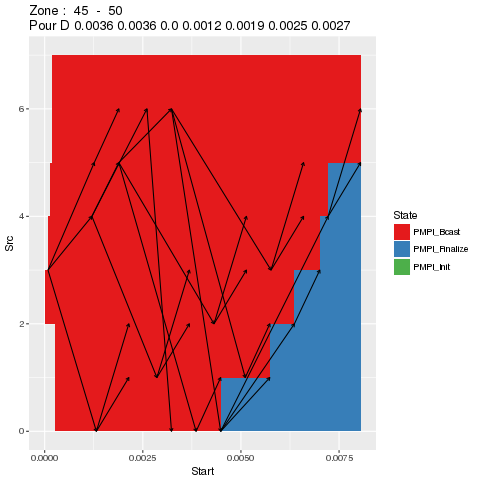

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0 0 0 0.00116 0.00116 ...
 $ End     : num  0.00116 0.00116 0.00116 0.00178 0.00178 ...
 $ Duration: num  0.001157 0.001157 0.001157 0.000626 0.000626 ...
 $ Src     : num  1 1 1 2 3 5 5 2 2 3 ...
 $ Dst     : num  2 3 5 3 4 6 0 4 6 4 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_21",..: 5 6 8 10 16 27 23 12 13 15 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.001984 0.001984    PMPI_Bcast
3     6 0.001984 0.002723 0.000739    PMPI_Bcast
4     6 0.002723 0.004425 0.001702    PMPI_Bcast
5     6 0.004425 0.005051 0.000626    PMPI_Bcast
6     6 0.005051 0.005677 0.000626    PMPI_Bcast
7     6 0.005677 0.007935 0.002258 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.001157 0.001157    PMPI_Bcast
10    5 0.001157 0.003148 0.001991    PMPI_Bcast
11    5 0.003148 0.003799 0.000651    PMPI_Bcast
12    5 0.003799 0.004425 0.000626    PMPI_Bcast
13    5 0.004425 0.004425 0.000000    PMPI_Bcast
14    5 0.004425 0.007935 0.003510 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.001783 0.001783    PMPI_Bcast
17    4 0.001783 0.002522 0.000739    PMPI_Bcast
18    4 0.002522 0.003148 0.000626    PMPI_Bcast
19    4 0.003148 0.003148 0.000000    PMPI_Bcast
20    4 0.003148 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001157 0.001157   1   2  1_2_-3334_3
2  0.000000 0.001157 0.001157   1   3  1_3_-3334_2
3  0.000000 0.001157 0.001157   1   5  1_5_-3334_1
4  0.001157 0.001783 0.000626   2   3  2_3_-3334_9
5  0.001157 0.001783 0.000626   3   4  3_4_-3334_5
6  0.001157 0.001984 0.000827   5   6  5_6_-3334_8
7  0.001157 0.001984 0.000827   5   0  5_0_-3334_6
8  0.001157 0.002522 0.001365   2   4  2_4_-3334_7
9  0.001157 0.002723 0.001566   2   6  2_6_-3334_4
10 0.001783 0.003148 0.001365   3   4 3_4_-3334_12
11 0.002522 0.003148 0.000626   4   5 4_5_-3334_13
12 0.002723 0.003551 0.000828   6   0 6_0_-3334_15
13 0.002723 0.003551 0.000828   6   1 6_1_-3334_14
14 0.001783 0.003799 0.002016   3   5 3_5_-3334_11
15 0.001783 0.004201 0.002418   3   0 3_0_-3334_10
16 0.003148 0.004425 0.001277   4   5 4_5_-3334_18
17 0.003799 0.004425 0.000626   5   6 5_6_-3334_19
18 0.004201 0.005028 0.000827   0   1 0_1_-3334_21
19 0.004201 0.005028 0.000827  

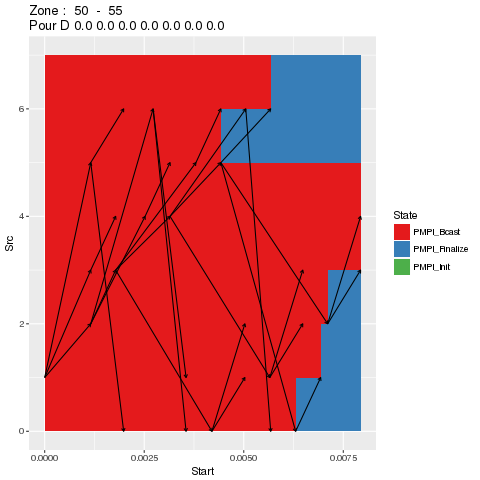

T_curr :  45
D_curr :  0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027
Dprime :  0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0013
total execution time :  0.04039999999999999

merging : 0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027

  || RESULTS || 

TO EXPLORE : 
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027', 2, 0, 0.0045)
10
	0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
		('0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036', 2, 1, 0.0045)
15
	0.0 0.00

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001122 0.001183 0.001231 0.000687 0.000626 ...
 $ Src     : num  1 1 1 2 3 5 5 2 2 3 ...
 $ Dst     : num  2 3 5 3 4 6 0 4 6 4 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_21",..: 5 6 8 10 16 27 23 12 13 15 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000245 0.002143 0.001898    PMPI_Bcast
3     6 0.002143 0.002860 0.000717    PMPI_Bcast
4     6 0.002860 0.004492 0.001632    PMPI_Bcast
5     6 0.004492 0.005118 0.000626    PMPI_Bcast
6     6 0.005118 0.005744 0.000626    PMPI_Bcast
7     6 0.005744 0.008052 0.002308 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000245 0.001315 0.001070    PMPI_Bcast
10    5 0.001315 0.003236 0.001921    PMPI_Bcast
11    5 0.003236 0.003866 0.000630    PMPI_Bcast
12    5 0.003866 0.004492 0.000626    PMPI_Bcast
13    5 0.004492 0.004492 0.000000    PMPI_Bcast
14    5 0.004492 0.008052 0.003560 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000189 0.001893 0.001704    PMPI_Bcast
17    4 0.001893 0.002610 0.000717    PMPI_Bcast
18    4 0.002610 0.003236 0.000626    PMPI_Bcast
19    4 0.003236 0.003236 0.000000    PMPI_Bcast
20    4 0.003236 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001206 0.001122   1   2  1_2_-3334_3
2  0.000084 0.001267 0.001183   1   3  1_3_-3334_2
3  0.000084 0.001315 0.001231   1   5  1_5_-3334_1
4  0.001206 0.001893 0.000687   2   3  2_3_-3334_6
5  0.001267 0.001893 0.000626   3   4  3_4_-3334_7
6  0.001315 0.002143 0.000828   5   6  5_6_-3334_9
7  0.001315 0.002143 0.000828   5   0  5_0_-3334_8
8  0.001206 0.002610 0.001404   2   4  2_4_-3334_5
9  0.001206 0.002860 0.001654   2   6  2_6_-3334_4
10 0.001893 0.003236 0.001343   3   4 3_4_-3334_12
11 0.002610 0.003236 0.000626   4   5 4_5_-3334_13
12 0.002860 0.003687 0.000827   6   0 6_0_-3334_15
13 0.002860 0.003687 0.000827   6   1 6_1_-3334_14
14 0.001893 0.003866 0.001973   3   5 3_5_-3334_11
15 0.001893 0.004317 0.002424   3   0 3_0_-3334_10
16 0.003236 0.004492 0.001256   4   5 4_5_-3334_18
17 0.003866 0.004492 0.000626   5   6 5_6_-3334_19
18 0.003236 0.005118 0.001882   4   6 4_6_-3334_17
19 0.004317 0.005144 0.000827  

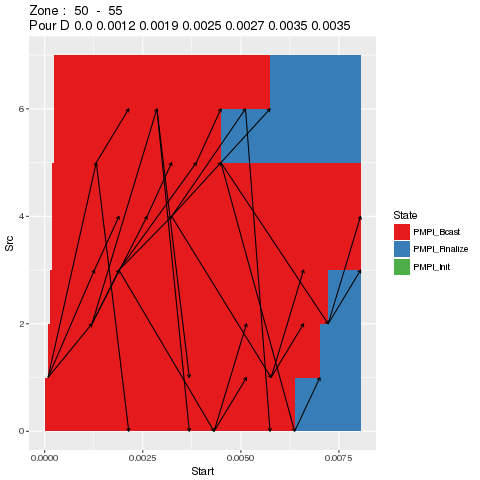

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000091 0.000091 0.000091 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001115 0.001176 0.001224 0.000687 0.000626 ...
 $ Src     : num  6 6 6 0 1 3 3 0 0 1 ...
 $ Dst     : num  0 1 3 1 2 4 5 2 4 2 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_30",..: 27 28 30 2 7 17 19 4 5 6 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000091 0.000091 0.000000    PMPI_Bcast
3     6 0.000091 0.003687 0.003596    PMPI_Bcast
4     6 0.003687 0.005144 0.001457    PMPI_Bcast
5     6 0.005144 0.005770 0.000626    PMPI_Bcast
6     6 0.005770 0.007015 0.001245    PMPI_Bcast
7     6 0.007015 0.008052 0.001037 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.002143 0.002143    PMPI_Bcast
10    5 0.002143 0.003687 0.001544    PMPI_Bcast
11    5 0.003687 0.004317 0.000630    PMPI_Bcast
12    5 0.004317 0.005744 0.001427    PMPI_Bcast
13    5 0.005744 0.006370 0.000626    PMPI_Bcast
14    5 0.006370 0.008052 0.001682 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000245 0.002143 0.001898    PMPI_Bcast
17    4 0.002143 0.002860 0.000717    PMPI_Bcast
18    4 0.002860 0.004492 0.001632    PMPI_Bcast
19    4 0.004492 0.005118 0.000626    PMPI_Bcast
20    4 0.005118 0.0

      Start      End Duration Src Dst           NA
1  0.000091 0.001206 0.001115   6   0  6_0_-3334_3
2  0.000091 0.001267 0.001176   6   1  6_1_-3334_2
3  0.000091 0.001315 0.001224   6   3  6_3_-3334_1
4  0.001206 0.001893 0.000687   0   1  0_1_-3334_6
5  0.001267 0.001893 0.000626   1   2  1_2_-3334_7
6  0.001315 0.002143 0.000828   3   4  3_4_-3334_9
7  0.001315 0.002143 0.000828   3   5  3_5_-3334_8
8  0.001206 0.002610 0.001404   0   2  0_2_-3334_5
9  0.001206 0.002860 0.001654   0   4  0_4_-3334_4
10 0.001893 0.003236 0.001343   1   2 1_2_-3334_12
11 0.002610 0.003236 0.000626   2   3 2_3_-3334_13
12 0.002860 0.003687 0.000827   4   5 4_5_-3334_15
13 0.002860 0.003687 0.000827   4   6 4_6_-3334_14
14 0.001893 0.003866 0.001973   1   3 1_3_-3334_11
15 0.001893 0.004317 0.002424   1   5 1_5_-3334_10
16 0.003236 0.004492 0.001256   2   3 2_3_-3334_18
17 0.003866 0.004492 0.000626   3   4 3_4_-3334_19
18 0.003236 0.005118 0.001882   2   4 2_4_-3334_17
19 0.004317 0.005144 0.000827  

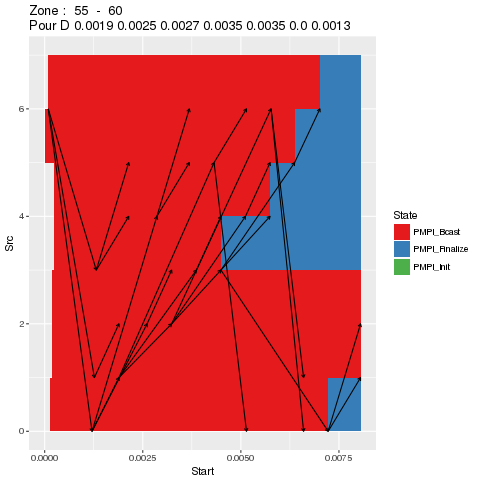

T_curr :  50
D_curr :  0.0 0.0012 0.0019 0.0025 0.0027 0.0035 0.0035
Dprime :  0.0027 0.0036 0.0036 0.0 0.0012 0.0019 0.0025
total execution time :  0.04489999999999999

merging : 0.0 0.0012 0.0019 0.0025 0.0027 0.0035 0.0035
merging : 0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0013
****** SUCCESS : 2

  || RESULTS || 

TO EXPLORE : 
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027', 2, 0, 0.0045)
10
	0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
		(

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001203 0.001263 ...
 $ End     : num  0.0012 0.00126 0.00132 0.00189 0.00189 ...
 $ Duration: num  0.001119 0.001179 0.001233 0.000686 0.000626 ...
 $ Src     : num  4 4 4 5 6 1 1 5 5 6 ...
 $ Dst     : num  5 6 1 6 0 2 3 0 2 0 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_13",..: 19 20 17 26 28 7 9 23 24 27 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000175 0.001263 0.001088    PMPI_Bcast
3     6 0.001263 0.001889 0.000626    PMPI_Bcast
4     6 0.001889 0.001889 0.000000    PMPI_Bcast
5     6 0.001889 0.006596 0.004707    PMPI_Bcast
6     6 0.006596 0.008049 0.001453    PMPI_Bcast
7     6 0.008049 0.008049 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000133 0.001203 0.001070    PMPI_Bcast
10    5 0.001203 0.001203 0.000000    PMPI_Bcast
11    5 0.001203 0.005141 0.003938    PMPI_Bcast
12    5 0.005141 0.006596 0.001455    PMPI_Bcast
13    5 0.006596 0.007222 0.000626    PMPI_Bcast
14    5 0.007222 0.008049 0.000827 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000084 0.000084 0.000000    PMPI_Bcast
17    4 0.000084 0.003687 0.003603    PMPI_Bcast
18    4 0.003687 0.005141 0.001454    PMPI_Bcast
19    4 0.005141 0.005767 0.000626    PMPI_Bcast
20    4 0.005767 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001203 0.001119   4   5  4_5_-3334_3
2  0.000084 0.001263 0.001179   4   6  4_6_-3334_2
3  0.000084 0.001317 0.001233   4   1  4_1_-3334_1
4  0.001203 0.001889 0.000686   5   6  5_6_-3334_6
5  0.001263 0.001889 0.000626   6   0  6_0_-3334_7
6  0.001317 0.002144 0.000827   1   2  1_2_-3334_9
7  0.001317 0.002144 0.000827   1   3  1_3_-3334_8
8  0.001203 0.002605 0.001402   5   0  5_0_-3334_5
9  0.001203 0.002859 0.001656   5   2  5_2_-3334_4
10 0.001889 0.003231 0.001342   6   0 6_0_-3334_12
11 0.002605 0.003231 0.000626   0   1 0_1_-3334_13
12 0.002859 0.003687 0.000828   2   3 2_3_-3334_15
13 0.002859 0.003687 0.000828   2   4 2_4_-3334_14
14 0.001889 0.003858 0.001969   6   1 6_1_-3334_11
15 0.001889 0.004314 0.002425   6   3 6_3_-3334_10
16 0.003231 0.004484 0.001253   0   1 0_1_-3334_18
17 0.003858 0.004484 0.000626   1   2 1_2_-3334_19
18 0.003231 0.005110 0.001879   0   2 0_2_-3334_17
19 0.004314 0.005141 0.000827  

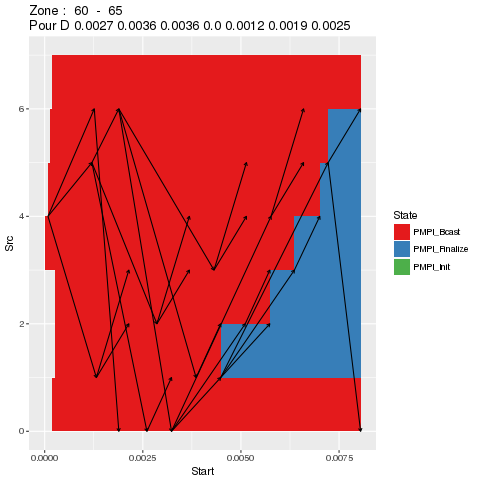

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0 0 0 0.00116 0.00116 ...
 $ End     : num  0.00116 0.00116 0.00116 0.00178 0.00178 ...
 $ Duration: num  0.001157 0.001157 0.001157 0.000626 0.000626 ...
 $ Src     : num  2 2 2 3 4 6 6 3 3 4 ...
 $ Dst     : num  3 4 6 4 5 0 1 5 0 5 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_15",..: 8 9 11 14 19 27 29 16 12 18 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.001157 0.001157    PMPI_Bcast
3     6 0.001157 0.003148 0.001991    PMPI_Bcast
4     6 0.003148 0.003799 0.000651    PMPI_Bcast
5     6 0.003799 0.004425 0.000626    PMPI_Bcast
6     6 0.004425 0.004425 0.000000    PMPI_Bcast
7     6 0.004425 0.007935 0.003510 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.001783 0.001783    PMPI_Bcast
10    5 0.001783 0.002522 0.000739    PMPI_Bcast
11    5 0.002522 0.003148 0.000626    PMPI_Bcast
12    5 0.003148 0.003148 0.000000    PMPI_Bcast
13    5 0.003148 0.007935 0.004787    PMPI_Bcast
14    5 0.007935 0.007935 0.000000 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.001157 0.001157    PMPI_Bcast
17    4 0.001157 0.001783 0.000626    PMPI_Bcast
18    4 0.001783 0.001783 0.000000    PMPI_Bcast
19    4 0.001783 0.006482 0.004699    PMPI_Bcast
20    4 0.006482 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001157 0.001157   2   3  2_3_-3334_3
2  0.000000 0.001157 0.001157   2   4  2_4_-3334_2
3  0.000000 0.001157 0.001157   2   6  2_6_-3334_1
4  0.001157 0.001783 0.000626   3   4  3_4_-3334_9
5  0.001157 0.001783 0.000626   4   5  4_5_-3334_5
6  0.001157 0.001984 0.000827   6   0  6_0_-3334_8
7  0.001157 0.001984 0.000827   6   1  6_1_-3334_6
8  0.001157 0.002522 0.001365   3   5  3_5_-3334_7
9  0.001157 0.002723 0.001566   3   0  3_0_-3334_4
10 0.001783 0.003148 0.001365   4   5 4_5_-3334_12
11 0.002522 0.003148 0.000626   5   6 5_6_-3334_13
12 0.002723 0.003551 0.000828   0   1 0_1_-3334_15
13 0.002723 0.003551 0.000828   0   2 0_2_-3334_14
14 0.001783 0.003799 0.002016   4   6 4_6_-3334_11
15 0.001783 0.004201 0.002418   4   1 4_1_-3334_10
16 0.003148 0.004425 0.001277   5   6 5_6_-3334_18
17 0.003799 0.004425 0.000626   6   0 6_0_-3334_19
18 0.004201 0.005028 0.000827   1   2 1_2_-3334_21
19 0.004201 0.005028 0.000827  

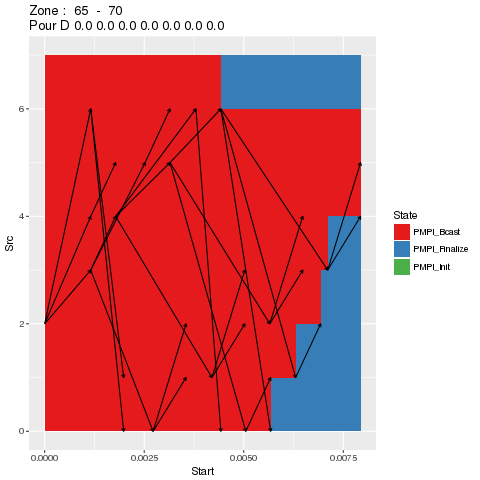

T_curr :  60
D_curr :  0.0027 0.0036 0.0036 0.0 0.0012 0.0019 0.0025
Dprime :  0.0013 0.0019 0.0025 0.0027 0.0035 0.0035 0.0
total execution time :  0.05389999999999998

merging : 0.0027 0.0036 0.0036 0.0 0.0012 0.0019 0.0025

  || RESULTS || 

TO EXPLORE : 
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027', 2, 0, 0.0045)
10
	0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
		('0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036', 2, 1, 0.0045)
15
	0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036
		('0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0012', 3, 0, 0.0045

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001122 0.001183 0.001231 0.000687 0.000626 ...
 $ Src     : num  2 2 2 3 4 6 6 3 3 4 ...
 $ Dst     : num  3 4 6 4 5 0 1 5 0 5 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_15",..: 8 9 11 14 19 27 29 16 12 18 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000245 0.001315 0.001070    PMPI_Bcast
3     6 0.001315 0.003236 0.001921    PMPI_Bcast
4     6 0.003236 0.003866 0.000630    PMPI_Bcast
5     6 0.003866 0.004492 0.000626    PMPI_Bcast
6     6 0.004492 0.004492 0.000000    PMPI_Bcast
7     6 0.004492 0.008052 0.003560 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000189 0.001893 0.001704    PMPI_Bcast
10    5 0.001893 0.002610 0.000717    PMPI_Bcast
11    5 0.002610 0.003236 0.000626    PMPI_Bcast
12    5 0.003236 0.003236 0.000000    PMPI_Bcast
13    5 0.003236 0.008052 0.004816    PMPI_Bcast
14    5 0.008052 0.008052 0.000000 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000175 0.001267 0.001092    PMPI_Bcast
17    4 0.001267 0.001893 0.000626    PMPI_Bcast
18    4 0.001893 0.001893 0.000000    PMPI_Bcast
19    4 0.001893 0.006599 0.004706    PMPI_Bcast
20    4 0.006599 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001206 0.001122   2   3  2_3_-3334_3
2  0.000084 0.001267 0.001183   2   4  2_4_-3334_2
3  0.000084 0.001315 0.001231   2   6  2_6_-3334_1
4  0.001206 0.001893 0.000687   3   4  3_4_-3334_6
5  0.001267 0.001893 0.000626   4   5  4_5_-3334_7
6  0.001315 0.002143 0.000828   6   0  6_0_-3334_9
7  0.001315 0.002143 0.000828   6   1  6_1_-3334_8
8  0.001206 0.002610 0.001404   3   5  3_5_-3334_5
9  0.001206 0.002860 0.001654   3   0  3_0_-3334_4
10 0.001893 0.003236 0.001343   4   5 4_5_-3334_12
11 0.002610 0.003236 0.000626   5   6 5_6_-3334_13
12 0.002860 0.003687 0.000827   0   1 0_1_-3334_15
13 0.002860 0.003687 0.000827   0   2 0_2_-3334_14
14 0.001893 0.003866 0.001973   4   6 4_6_-3334_11
15 0.001893 0.004317 0.002424   4   1 4_1_-3334_10
16 0.003236 0.004492 0.001256   5   6 5_6_-3334_18
17 0.003866 0.004492 0.000626   6   0 6_0_-3334_19
18 0.003236 0.005118 0.001882   5   0 5_0_-3334_17
19 0.004317 0.005144 0.000827  

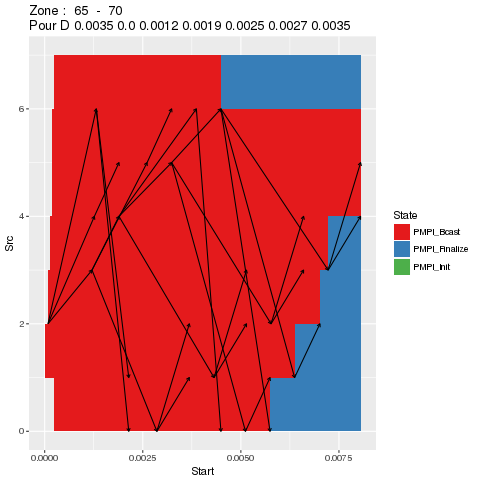

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000091 0.000091 0.000091 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001115 0.001176 0.001224 0.000687 0.000626 ...
 $ Src     : num  0 0 0 1 2 4 4 1 1 2 ...
 $ Dst     : num  1 2 4 2 3 5 6 3 5 3 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_27",..: 2 3 5 7 12 22 24 9 10 11 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.002143 0.002143    PMPI_Bcast
3     6 0.002143 0.003687 0.001544    PMPI_Bcast
4     6 0.003687 0.004317 0.000630    PMPI_Bcast
5     6 0.004317 0.005744 0.001427    PMPI_Bcast
6     6 0.005744 0.006370 0.000626    PMPI_Bcast
7     6 0.006370 0.008052 0.001682 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000245 0.002143 0.001898    PMPI_Bcast
10    5 0.002143 0.002860 0.000717    PMPI_Bcast
11    5 0.002860 0.004492 0.001632    PMPI_Bcast
12    5 0.004492 0.005118 0.000626    PMPI_Bcast
13    5 0.005118 0.005744 0.000626    PMPI_Bcast
14    5 0.005744 0.008052 0.002308 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000245 0.001315 0.001070    PMPI_Bcast
17    4 0.001315 0.003236 0.001921    PMPI_Bcast
18    4 0.003236 0.003866 0.000630    PMPI_Bcast
19    4 0.003866 0.004492 0.000626    PMPI_Bcast
20    4 0.004492 0.0

      Start      End Duration Src Dst           NA
1  0.000091 0.001206 0.001115   0   1  0_1_-3334_3
2  0.000091 0.001267 0.001176   0   2  0_2_-3334_2
3  0.000091 0.001315 0.001224   0   4  0_4_-3334_1
4  0.001206 0.001893 0.000687   1   2  1_2_-3334_6
5  0.001267 0.001893 0.000626   2   3  2_3_-3334_7
6  0.001315 0.002143 0.000828   4   5  4_5_-3334_9
7  0.001315 0.002143 0.000828   4   6  4_6_-3334_8
8  0.001206 0.002610 0.001404   1   3  1_3_-3334_5
9  0.001206 0.002860 0.001654   1   5  1_5_-3334_4
10 0.001893 0.003236 0.001343   2   3 2_3_-3334_12
11 0.002610 0.003236 0.000626   3   4 3_4_-3334_13
12 0.002860 0.003687 0.000827   5   6 5_6_-3334_15
13 0.002860 0.003687 0.000827   5   0 5_0_-3334_14
14 0.001893 0.003866 0.001973   2   4 2_4_-3334_11
15 0.001893 0.004317 0.002424   2   6 2_6_-3334_10
16 0.003236 0.004492 0.001256   3   4 3_4_-3334_18
17 0.003866 0.004492 0.000626   4   5 4_5_-3334_19
18 0.003236 0.005118 0.001882   3   5 3_5_-3334_17
19 0.004317 0.005144 0.000827  

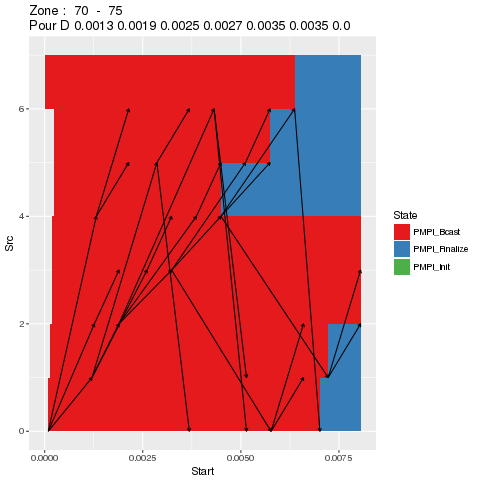

T_curr :  65
D_curr :  0.0035 0.0 0.0012 0.0019 0.0025 0.0027 0.0035
Dprime :  0.0025 0.0027 0.0036 0.0036 0.0 0.0012 0.0019
total execution time :  0.05839999999999998

merging : 0.0035 0.0 0.0012 0.0019 0.0025 0.0027 0.0035
merging : 0.0013 0.0019 0.0025 0.0027 0.0035 0.0035 0.0
****** SUCCESS : 2

  || RESULTS || 

TO EXPLORE : 
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027', 2, 0, 0.0045)
10
	0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
		('0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036', 2, 1, 0.0045)
15
	0.0 0.0012 0.0019 0.0025 0.0027 0.0

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001203 0.001263 ...
 $ End     : num  0.0012 0.00126 0.00132 0.00189 0.00189 ...
 $ Duration: num  0.001119 0.001179 0.001233 0.000686 0.000626 ...
 $ Src     : num  5 5 5 6 0 2 2 6 6 0 ...
 $ Dst     : num  6 0 2 0 1 3 4 1 3 1 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_12",..: 25 21 23 27 2 11 13 29 30 1 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000133 0.001203 0.001070    PMPI_Bcast
3     6 0.001203 0.001203 0.000000    PMPI_Bcast
4     6 0.001203 0.005141 0.003938    PMPI_Bcast
5     6 0.005141 0.006596 0.001455    PMPI_Bcast
6     6 0.006596 0.007222 0.000626    PMPI_Bcast
7     6 0.007222 0.008049 0.000827 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000084 0.000084 0.000000    PMPI_Bcast
10    5 0.000084 0.003687 0.003603    PMPI_Bcast
11    5 0.003687 0.005141 0.001454    PMPI_Bcast
12    5 0.005141 0.005767 0.000626    PMPI_Bcast
13    5 0.005767 0.007009 0.001242    PMPI_Bcast
14    5 0.007009 0.008049 0.001040 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.002144 0.002144    PMPI_Bcast
17    4 0.002144 0.003687 0.001543    PMPI_Bcast
18    4 0.003687 0.004314 0.000627    PMPI_Bcast
19    4 0.004314 0.005736 0.001422    PMPI_Bcast
20    4 0.005736 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001203 0.001119   5   6  5_6_-3334_3
2  0.000084 0.001263 0.001179   5   0  5_0_-3334_2
3  0.000084 0.001317 0.001233   5   2  5_2_-3334_1
4  0.001203 0.001889 0.000686   6   0  6_0_-3334_6
5  0.001263 0.001889 0.000626   0   1  0_1_-3334_7
6  0.001317 0.002144 0.000827   2   3  2_3_-3334_9
7  0.001317 0.002144 0.000827   2   4  2_4_-3334_8
8  0.001203 0.002605 0.001402   6   1  6_1_-3334_5
9  0.001203 0.002859 0.001656   6   3  6_3_-3334_4
10 0.001889 0.003231 0.001342   0   1 0_1_-3334_12
11 0.002605 0.003231 0.000626   1   2 1_2_-3334_13
12 0.002859 0.003687 0.000828   3   4 3_4_-3334_15
13 0.002859 0.003687 0.000828   3   5 3_5_-3334_14
14 0.001889 0.003858 0.001969   0   2 0_2_-3334_11
15 0.001889 0.004314 0.002425   0   4 0_4_-3334_10
16 0.003231 0.004484 0.001253   1   2 1_2_-3334_18
17 0.003858 0.004484 0.000626   2   3 2_3_-3334_19
18 0.003231 0.005110 0.001879   1   3 1_3_-3334_17
19 0.004314 0.005141 0.000827  

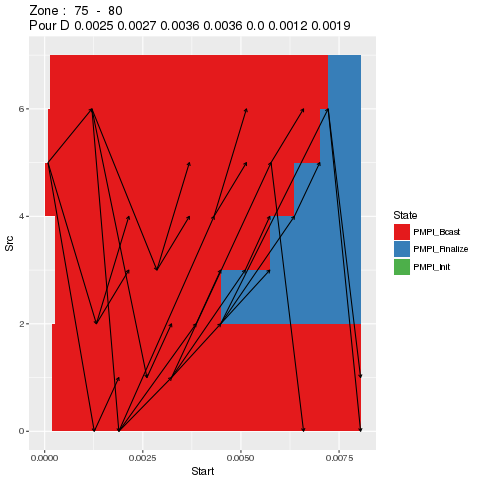

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0 0 0 0.00116 0.00116 ...
 $ End     : num  0.00116 0.00116 0.00116 0.00178 0.00178 ...
 $ Duration: num  0.001157 0.001157 0.001157 0.000626 0.000626 ...
 $ Src     : num  3 3 3 4 5 0 0 4 4 5 ...
 $ Dst     : num  4 5 0 5 6 1 2 6 1 6 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_19",..: 15 16 13 20 26 3 5 22 18 25 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.001783 0.001783    PMPI_Bcast
3     6 0.001783 0.002522 0.000739    PMPI_Bcast
4     6 0.002522 0.003148 0.000626    PMPI_Bcast
5     6 0.003148 0.003148 0.000000    PMPI_Bcast
6     6 0.003148 0.007935 0.004787    PMPI_Bcast
7     6 0.007935 0.007935 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.001157 0.001157    PMPI_Bcast
10    5 0.001157 0.001783 0.000626    PMPI_Bcast
11    5 0.001783 0.001783 0.000000    PMPI_Bcast
12    5 0.001783 0.006482 0.004699    PMPI_Bcast
13    5 0.006482 0.007935 0.001453    PMPI_Bcast
14    5 0.007935 0.007935 0.000000 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.001157 0.001157    PMPI_Bcast
17    4 0.001157 0.001157 0.000000    PMPI_Bcast
18    4 0.001157 0.005028 0.003871    PMPI_Bcast
19    4 0.005028 0.006482 0.001454    PMPI_Bcast
20    4 0.006482 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001157 0.001157   3   4  3_4_-3334_3
2  0.000000 0.001157 0.001157   3   5  3_5_-3334_2
3  0.000000 0.001157 0.001157   3   0  3_0_-3334_1
4  0.001157 0.001783 0.000626   4   5  4_5_-3334_9
5  0.001157 0.001783 0.000626   5   6  5_6_-3334_5
6  0.001157 0.001984 0.000827   0   1  0_1_-3334_8
7  0.001157 0.001984 0.000827   0   2  0_2_-3334_6
8  0.001157 0.002522 0.001365   4   6  4_6_-3334_7
9  0.001157 0.002723 0.001566   4   1  4_1_-3334_4
10 0.001783 0.003148 0.001365   5   6 5_6_-3334_12
11 0.002522 0.003148 0.000626   6   0 6_0_-3334_13
12 0.002723 0.003551 0.000828   1   2 1_2_-3334_15
13 0.002723 0.003551 0.000828   1   3 1_3_-3334_14
14 0.001783 0.003799 0.002016   5   0 5_0_-3334_11
15 0.001783 0.004201 0.002418   5   2 5_2_-3334_10
16 0.003148 0.004425 0.001277   6   0 6_0_-3334_18
17 0.003799 0.004425 0.000626   0   1 0_1_-3334_19
18 0.004201 0.005028 0.000827   2   3 2_3_-3334_21
19 0.004201 0.005028 0.000827  

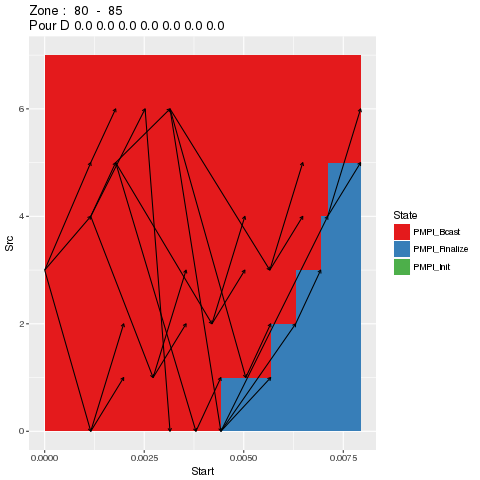

T_curr :  75
D_curr :  0.0025 0.0027 0.0036 0.0036 0.0 0.0012 0.0019
Dprime :  0.0 0.0013 0.0019 0.0025 0.0027 0.0035 0.0035
total execution time :  0.06739999999999999

merging : 0.0025 0.0027 0.0036 0.0036 0.0 0.0012 0.0019

  || RESULTS || 

TO EXPLORE : 
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027', 2, 0, 0.0045)
10
	0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
		('0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036', 2, 1, 0.0045)
15
	0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036
		('0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0012', 3, 0, 0.0045)
20
	0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0012
		('0.0027 0.0036 0.0036 0.0 0.0012 0.0019 0.0025'

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001122 0.001183 0.001231 0.000687 0.000626 ...
 $ Src     : num  3 3 3 4 5 0 0 4 4 5 ...
 $ Dst     : num  4 5 0 5 6 1 2 6 1 6 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_19",..: 15 16 13 20 26 3 5 22 18 25 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000189 0.001893 0.001704    PMPI_Bcast
3     6 0.001893 0.002610 0.000717    PMPI_Bcast
4     6 0.002610 0.003236 0.000626    PMPI_Bcast
5     6 0.003236 0.003236 0.000000    PMPI_Bcast
6     6 0.003236 0.008052 0.004816    PMPI_Bcast
7     6 0.008052 0.008052 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000175 0.001267 0.001092    PMPI_Bcast
10    5 0.001267 0.001893 0.000626    PMPI_Bcast
11    5 0.001893 0.001893 0.000000    PMPI_Bcast
12    5 0.001893 0.006599 0.004706    PMPI_Bcast
13    5 0.006599 0.008052 0.001453    PMPI_Bcast
14    5 0.008052 0.008052 0.000000 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000133 0.001206 0.001073    PMPI_Bcast
17    4 0.001206 0.001206 0.000000    PMPI_Bcast
18    4 0.001206 0.005144 0.003938    PMPI_Bcast
19    4 0.005144 0.006599 0.001455    PMPI_Bcast
20    4 0.006599 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001206 0.001122   3   4  3_4_-3334_3
2  0.000084 0.001267 0.001183   3   5  3_5_-3334_2
3  0.000084 0.001315 0.001231   3   0  3_0_-3334_1
4  0.001206 0.001893 0.000687   4   5  4_5_-3334_6
5  0.001267 0.001893 0.000626   5   6  5_6_-3334_7
6  0.001315 0.002143 0.000828   0   1  0_1_-3334_9
7  0.001315 0.002143 0.000828   0   2  0_2_-3334_8
8  0.001206 0.002610 0.001404   4   6  4_6_-3334_5
9  0.001206 0.002860 0.001654   4   1  4_1_-3334_4
10 0.001893 0.003236 0.001343   5   6 5_6_-3334_12
11 0.002610 0.003236 0.000626   6   0 6_0_-3334_13
12 0.002860 0.003687 0.000827   1   2 1_2_-3334_15
13 0.002860 0.003687 0.000827   1   3 1_3_-3334_14
14 0.001893 0.003866 0.001973   5   0 5_0_-3334_11
15 0.001893 0.004317 0.002424   5   2 5_2_-3334_10
16 0.003236 0.004492 0.001256   6   0 6_0_-3334_18
17 0.003866 0.004492 0.000626   0   1 0_1_-3334_19
18 0.003236 0.005118 0.001882   6   1 6_1_-3334_17
19 0.004317 0.005144 0.000827  

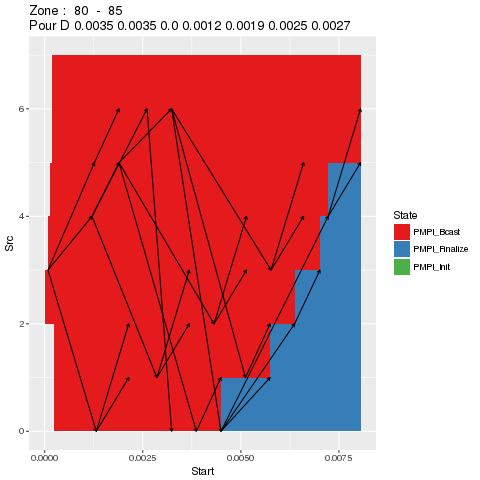

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000091 0.000091 0.000091 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001115 0.001176 0.001224 0.000687 0.000626 ...
 $ Src     : num  1 1 1 2 3 5 5 2 2 3 ...
 $ Dst     : num  2 3 5 3 4 6 0 4 6 4 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_21",..: 5 6 8 10 16 27 23 12 13 15 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000245 0.002143 0.001898    PMPI_Bcast
3     6 0.002143 0.002860 0.000717    PMPI_Bcast
4     6 0.002860 0.004492 0.001632    PMPI_Bcast
5     6 0.004492 0.005118 0.000626    PMPI_Bcast
6     6 0.005118 0.005744 0.000626    PMPI_Bcast
7     6 0.005744 0.008052 0.002308 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000245 0.001315 0.001070    PMPI_Bcast
10    5 0.001315 0.003236 0.001921    PMPI_Bcast
11    5 0.003236 0.003866 0.000630    PMPI_Bcast
12    5 0.003866 0.004492 0.000626    PMPI_Bcast
13    5 0.004492 0.004492 0.000000    PMPI_Bcast
14    5 0.004492 0.008052 0.003560 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000189 0.001893 0.001704    PMPI_Bcast
17    4 0.001893 0.002610 0.000717    PMPI_Bcast
18    4 0.002610 0.003236 0.000626    PMPI_Bcast
19    4 0.003236 0.003236 0.000000    PMPI_Bcast
20    4 0.003236 0.0

      Start      End Duration Src Dst           NA
1  0.000091 0.001206 0.001115   1   2  1_2_-3334_3
2  0.000091 0.001267 0.001176   1   3  1_3_-3334_2
3  0.000091 0.001315 0.001224   1   5  1_5_-3334_1
4  0.001206 0.001893 0.000687   2   3  2_3_-3334_6
5  0.001267 0.001893 0.000626   3   4  3_4_-3334_7
6  0.001315 0.002143 0.000828   5   6  5_6_-3334_9
7  0.001315 0.002143 0.000828   5   0  5_0_-3334_8
8  0.001206 0.002610 0.001404   2   4  2_4_-3334_5
9  0.001206 0.002860 0.001654   2   6  2_6_-3334_4
10 0.001893 0.003236 0.001343   3   4 3_4_-3334_12
11 0.002610 0.003236 0.000626   4   5 4_5_-3334_13
12 0.002860 0.003687 0.000827   6   0 6_0_-3334_15
13 0.002860 0.003687 0.000827   6   1 6_1_-3334_14
14 0.001893 0.003866 0.001973   3   5 3_5_-3334_11
15 0.001893 0.004317 0.002424   3   0 3_0_-3334_10
16 0.003236 0.004492 0.001256   4   5 4_5_-3334_18
17 0.003866 0.004492 0.000626   5   6 5_6_-3334_19
18 0.003236 0.005118 0.001882   4   6 4_6_-3334_17
19 0.004317 0.005144 0.000827  

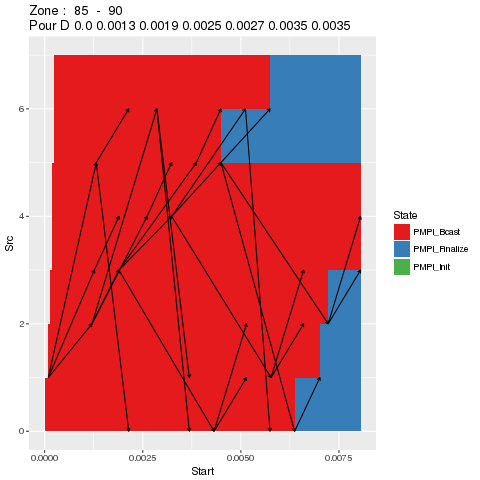

T_curr :  80
D_curr :  0.0035 0.0035 0.0 0.0012 0.0019 0.0025 0.0027
Dprime :  0.0019 0.0025 0.0027 0.0036 0.0036 0.0 0.0012
total execution time :  0.07189999999999999

merging : 0.0035 0.0035 0.0 0.0012 0.0019 0.0025 0.0027
merging : 0.0 0.0013 0.0019 0.0025 0.0027 0.0035 0.0035
****** SUCCESS : 2

  || RESULTS || 

TO EXPLORE : 
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027', 2, 0, 0.0045)
10
	0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
		('0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036', 2, 1, 0.0045)
15
	0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036
		('0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0012', 3, 0, 0.0045)
20
	0.0019 0.0025 0.0027 

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001203 0.001263 ...
 $ End     : num  0.0012 0.00126 0.00132 0.00189 0.00189 ...
 $ Duration: num  0.001119 0.001179 0.001233 0.000686 0.000626 ...
 $ Src     : num  6 6 6 0 1 3 3 0 0 1 ...
 $ Dst     : num  0 1 3 1 2 4 5 2 4 2 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_30",..: 27 28 30 2 7 17 19 4 5 6 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000084 0.000084 0.000000    PMPI_Bcast
3     6 0.000084 0.003687 0.003603    PMPI_Bcast
4     6 0.003687 0.005141 0.001454    PMPI_Bcast
5     6 0.005141 0.005767 0.000626    PMPI_Bcast
6     6 0.005767 0.007009 0.001242    PMPI_Bcast
7     6 0.007009 0.008049 0.001040 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.002144 0.002144    PMPI_Bcast
10    5 0.002144 0.003687 0.001543    PMPI_Bcast
11    5 0.003687 0.004314 0.000627    PMPI_Bcast
12    5 0.004314 0.005736 0.001422    PMPI_Bcast
13    5 0.005736 0.006362 0.000626    PMPI_Bcast
14    5 0.006362 0.008049 0.001687 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000252 0.002144 0.001892    PMPI_Bcast
17    4 0.002144 0.002859 0.000715    PMPI_Bcast
18    4 0.002859 0.004484 0.001625    PMPI_Bcast
19    4 0.004484 0.005110 0.000626    PMPI_Bcast
20    4 0.005110 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001203 0.001119   6   0  6_0_-3334_3
2  0.000084 0.001263 0.001179   6   1  6_1_-3334_2
3  0.000084 0.001317 0.001233   6   3  6_3_-3334_1
4  0.001203 0.001889 0.000686   0   1  0_1_-3334_6
5  0.001263 0.001889 0.000626   1   2  1_2_-3334_7
6  0.001317 0.002144 0.000827   3   4  3_4_-3334_9
7  0.001317 0.002144 0.000827   3   5  3_5_-3334_8
8  0.001203 0.002605 0.001402   0   2  0_2_-3334_5
9  0.001203 0.002859 0.001656   0   4  0_4_-3334_4
10 0.001889 0.003231 0.001342   1   2 1_2_-3334_12
11 0.002605 0.003231 0.000626   2   3 2_3_-3334_13
12 0.002859 0.003687 0.000828   4   5 4_5_-3334_15
13 0.002859 0.003687 0.000828   4   6 4_6_-3334_14
14 0.001889 0.003858 0.001969   1   3 1_3_-3334_11
15 0.001889 0.004314 0.002425   1   5 1_5_-3334_10
16 0.003231 0.004484 0.001253   2   3 2_3_-3334_18
17 0.003858 0.004484 0.000626   3   4 3_4_-3334_19
18 0.003231 0.005110 0.001879   2   4 2_4_-3334_17
19 0.004314 0.005141 0.000827  

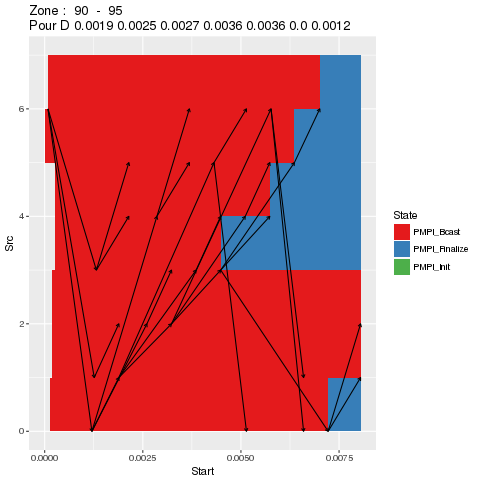

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0 0 0 0.00116 0.00116 ...
 $ End     : num  0.00116 0.00116 0.00116 0.00178 0.00178 ...
 $ Duration: num  0.001157 0.001157 0.001157 0.000626 0.000626 ...
 $ Src     : num  4 4 4 5 6 1 1 5 5 6 ...
 $ Dst     : num  5 6 1 6 0 2 3 0 2 0 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_13",..: 19 20 17 26 28 7 9 23 24 27 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.001157 0.001157    PMPI_Bcast
3     6 0.001157 0.001783 0.000626    PMPI_Bcast
4     6 0.001783 0.001783 0.000000    PMPI_Bcast
5     6 0.001783 0.006482 0.004699    PMPI_Bcast
6     6 0.006482 0.007935 0.001453    PMPI_Bcast
7     6 0.007935 0.007935 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.001157 0.001157    PMPI_Bcast
10    5 0.001157 0.001157 0.000000    PMPI_Bcast
11    5 0.001157 0.005028 0.003871    PMPI_Bcast
12    5 0.005028 0.006482 0.001454    PMPI_Bcast
13    5 0.006482 0.007108 0.000626    PMPI_Bcast
14    5 0.007108 0.007935 0.000827 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.000000 0.000000    PMPI_Bcast
17    4 0.000000 0.003551 0.003551    PMPI_Bcast
18    4 0.003551 0.005028 0.001477    PMPI_Bcast
19    4 0.005028 0.005654 0.000626    PMPI_Bcast
20    4 0.005654 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001157 0.001157   4   5  4_5_-3334_3
2  0.000000 0.001157 0.001157   4   6  4_6_-3334_2
3  0.000000 0.001157 0.001157   4   1  4_1_-3334_1
4  0.001157 0.001783 0.000626   5   6  5_6_-3334_9
5  0.001157 0.001783 0.000626   6   0  6_0_-3334_5
6  0.001157 0.001984 0.000827   1   2  1_2_-3334_8
7  0.001157 0.001984 0.000827   1   3  1_3_-3334_6
8  0.001157 0.002522 0.001365   5   0  5_0_-3334_7
9  0.001157 0.002723 0.001566   5   2  5_2_-3334_4
10 0.001783 0.003148 0.001365   6   0 6_0_-3334_12
11 0.002522 0.003148 0.000626   0   1 0_1_-3334_13
12 0.002723 0.003551 0.000828   2   3 2_3_-3334_15
13 0.002723 0.003551 0.000828   2   4 2_4_-3334_14
14 0.001783 0.003799 0.002016   6   1 6_1_-3334_11
15 0.001783 0.004201 0.002418   6   3 6_3_-3334_10
16 0.003148 0.004425 0.001277   0   1 0_1_-3334_18
17 0.003799 0.004425 0.000626   1   2 1_2_-3334_19
18 0.004201 0.005028 0.000827   3   4 3_4_-3334_21
19 0.004201 0.005028 0.000827  

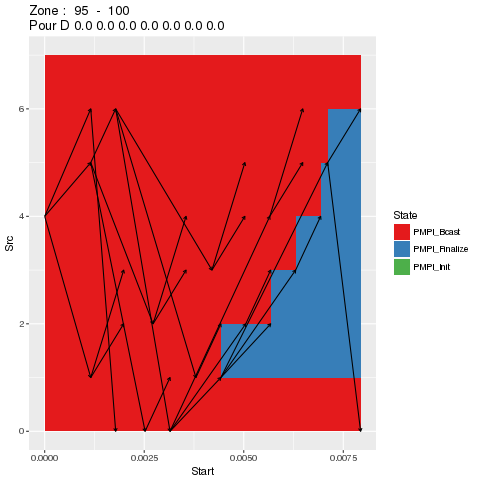

T_curr :  90
D_curr :  0.0019 0.0025 0.0027 0.0036 0.0036 0.0 0.0012
Dprime :  0.0035 0.0 0.0013 0.0019 0.0025 0.0027 0.0035
total execution time :  0.0809

merging : 0.0019 0.0025 0.0027 0.0036 0.0036 0.0 0.0012

  || RESULTS || 

TO EXPLORE : 
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027', 2, 0, 0.0045)
10
	0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
		('0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036', 2, 1, 0.0045)
15
	0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036
		('0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0012', 3, 0, 0.0045)
20
	0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0012
		('0.0027 0.0036 0.0036 0.0 0.0012 0.0019 0.0025', 4, 0, 0.0045)
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0027 0.0035 0.0035 0.0 0.0013 0.0019 0.0025', 3, 1, 0.0044)
25
	

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.000084 0.000084 0.000084 0.001206 0.001267 ...
 $ End     : num  0.00121 0.00127 0.00131 0.00189 0.00189 ...
 $ Duration: num  0.001122 0.001183 0.001231 0.000687 0.000626 ...
 $ Src     : num  4 4 4 5 6 1 1 5 5 6 ...
 $ Dst     : num  5 6 1 6 0 2 3 0 2 0 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_13",..: 19 20 17 26 28 7 9 23 24 27 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000175 0.001267 0.001092    PMPI_Bcast
3     6 0.001267 0.001893 0.000626    PMPI_Bcast
4     6 0.001893 0.001893 0.000000    PMPI_Bcast
5     6 0.001893 0.006599 0.004706    PMPI_Bcast
6     6 0.006599 0.008052 0.001453    PMPI_Bcast
7     6 0.008052 0.008052 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000133 0.001206 0.001073    PMPI_Bcast
10    5 0.001206 0.001206 0.000000    PMPI_Bcast
11    5 0.001206 0.005144 0.003938    PMPI_Bcast
12    5 0.005144 0.006599 0.001455    PMPI_Bcast
13    5 0.006599 0.007225 0.000626    PMPI_Bcast
14    5 0.007225 0.008052 0.000827 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000084 0.000084 0.000000    PMPI_Bcast
17    4 0.000084 0.003687 0.003603    PMPI_Bcast
18    4 0.003687 0.005144 0.001457    PMPI_Bcast
19    4 0.005144 0.005770 0.000626    PMPI_Bcast
20    4 0.005770 0.0

      Start      End Duration Src Dst           NA
1  0.000084 0.001206 0.001122   4   5  4_5_-3334_3
2  0.000084 0.001267 0.001183   4   6  4_6_-3334_2
3  0.000084 0.001315 0.001231   4   1  4_1_-3334_1
4  0.001206 0.001893 0.000687   5   6  5_6_-3334_6
5  0.001267 0.001893 0.000626   6   0  6_0_-3334_7
6  0.001315 0.002143 0.000828   1   2  1_2_-3334_9
7  0.001315 0.002143 0.000828   1   3  1_3_-3334_8
8  0.001206 0.002610 0.001404   5   0  5_0_-3334_5
9  0.001206 0.002860 0.001654   5   2  5_2_-3334_4
10 0.001893 0.003236 0.001343   6   0 6_0_-3334_12
11 0.002610 0.003236 0.000626   0   1 0_1_-3334_13
12 0.002860 0.003687 0.000827   2   3 2_3_-3334_15
13 0.002860 0.003687 0.000827   2   4 2_4_-3334_14
14 0.001893 0.003866 0.001973   6   1 6_1_-3334_11
15 0.001893 0.004317 0.002424   6   3 6_3_-3334_10
16 0.003236 0.004492 0.001256   0   1 0_1_-3334_18
17 0.003866 0.004492 0.000626   1   2 1_2_-3334_19
18 0.003236 0.005118 0.001882   0   2 0_2_-3334_17
19 0.004317 0.005144 0.000827  

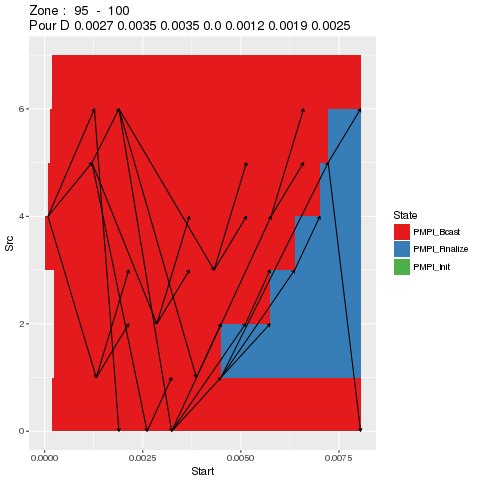

T_curr :  95
D_curr :  0.0027 0.0035 0.0035 0.0 0.0012 0.0019 0.0025
Dprime :  0.0036 0.0 0.0012 0.0019 0.0025 0.0027 0.0036
total execution time :  0.0854

merging : 0.0027 0.0035 0.0035 0.0 0.0012 0.0019 0.0025

  || RESULTS || 

TO EXPLORE : 
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0036 0.0036 0.0 0.0012 0.0019 0.0025 0.0027', 2, 0, 0.0045)
10
	0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
		('0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036', 2, 1, 0.0045)
15
	0.0 0.0012 0.0019 0.0025 0.0027 0.0036 0.0036
		('0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0012', 3, 0, 0.0045)
20
	0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0012
		('0.0027 0.0036 0.0036 0.0 0.0012 0.0019 0.0025', 4, 0, 0.0045)
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0027 0.0035 0.0035 0.0 0.0013 0.0019 0.0025', 3, 1, 0.0044)
25
	

In [32]:
DEBUG = True
# Nbr pcs
NPROCS = 7
    
# Nbr itérations
N = 100

# taille paquet d'itérations
fragment_size = 5

# Precision désirée pour le recollement des trajectoires
precision = 4

gap = 0.0005

# mode de génération de l'état initial à chaque round
mode_opt = ["FIX", "RAND", "RAND_INF", "RAND_SUP","SMART_GUESS","SMART_BORDERS"]
mode = mode_opt[0]

catch_me = False

# Lancement de la simulation
simulation(N, NPROCS, fragment_size, precision, mode, gap, catch_me)

#### Publication des résultats sur GitHub : https://github.com/HooBaeBoo/Stage-POLARIS

In [ ]:
%%bash -s $experiment_name $site
git add .
git commit -m 'Automatic results update : '"$1"' --- '"$2 "' Guess'

#### Fin d'expérience : suppression du job

In [ ]:
oardel([(jobid,site)])

### Zone Test (à ignorer)

In [ ]:
def help(q):
    %R -i q
    %R print(q)
help(2)

In [ ]:
a = [1, 2 ,3]
b = [2, 3, 4]
math.isclose(a, b, abs_tol = 2)

In [ ]:
tue = 6

In [ ]:
def play(tue):
    tue = tue -1
    return tue


a = play(tue)

while (a > 2):
    print(a)
    a = play(a)